# **Прогнозирование температуры звезды**

## Описание проекта

Цель — разработать нейронную сеть для предсказания абсолютной температуры на поверхности звезды с метрикой RMSE, не превышающей 4500.

В качестве входных данных: характеристики уже изученных 240 звёзд.

Характеристики следующие:
- Относительная светимость L/Lo — светимость звезды относительно
Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса
Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.

## Импорт библиотек и задание констант

In [1]:
# Стандартные библиотеки
import random
import time
from itertools import product
from math import ceil

# Машинное обучение и глубокое обучение
import torch
import torch.nn as nn
from torch.nn import init
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Научные вычисления и анализ данных
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Визуализация
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Статистика и моделирование
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Модели и предобработка данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Jupyter и отображение
from IPython.display import display, HTML

# Прогресс-бары и итерации
from tqdm import tqdm

# Специфичные утилиты
from phik.report import plot_correlation_matrix

# Игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Собственные функции
from utils import (
    extended_describe,
    plot_distribution_with_boxplot,
    create_sunburst_plot,
    phik_correlation_matrix,
    vif
)

In [3]:
# константа RANDOM_STATE
RANDOM_STATE = 42

# константа TEST_SIZE
TEST_SIZE = 0.25

# константы для обучения нейронной сети
BATCH_SIZE = 32 # считается, что размер батча, соответствующий степени 2, дает лучшие результаты
ACCUMULATION_STEPS = 2
NUM_EPOCHS = 10000
PRINT_EVERY = 100
PATIENCE = 5

## Загрузка данных

In [4]:
# считываем данные из csv-файла в датафрейм и сохраняем в переменную
try:
    df = pd.read_csv('/datasets/6_class.csv')
except:
    df = pd.read_csv('6_class.csv')

In [5]:
# сделаем копию датафрейма
data = df.copy()

In [6]:
# выведем первые 5 строк
data.head()

Unnamed: 0  Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  \
0           0             3068          0.002400        0.1700   
1           1             3042          0.000500        0.1542   
2           2             2600          0.000300        0.1020   
3           3             2800          0.000200        0.1600   
4           4             1939          0.000138        0.1030   

   Absolute magnitude(Mv)  Star type Star color  
0                   16.12          0        Red  
1                   16.60          0        Red  
2                   18.70          0        Red  
3                   16.65          0        Red  
4                   20.06          0        Red

Наблюдаем столбец `Unnamed: 0`, который повторяет индексы и не несет полезной информации. Поэтому удалим его.

In [7]:
# удалим столбец Unnamed: 0
data = data.drop(columns='Unnamed: 0')

**Промежуточный вывод**

Все данные из описания присутствуют, загрузка прошла успешно. Данные готовы к предобработке.

## Предобработка данных

Проверим данные на наличие пропусков и дубликатов. Узнаем, корректный ли тип данных у каждого признака.

In [8]:
# выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


Наблюдаем, что нет пропусков. Тип данных везде соответствует описанию, кроме столбца `Star type`. Из описания известно, какому числу соответствует какой тип звезды. Тем не менее, переведем тип данных в столбце `Star type` в строковый для удобства анализа. Перед обучением нейросети вернем тип в целочисленный.

In [9]:
# переведем тип данных Star type в строковый
data['Star type'] = data['Star type'].astype('str')

Проанализируем дубликаты.

In [10]:
# выведем количество явных дубликатов
data.duplicated().sum()

0

Явные дубликаты отсутствуют. Проверим наличие неявных дубликатов. Для этого выведем все уникальные значения категориальных столбцов.

In [11]:
# выведем уникальные значения в Star type
data['Star type'].unique()

array(['0', '1', '2', '3', '4', '5'], dtype=object)

В столбце `Star type` все значения уникальны без неявных дубликатов.

In [12]:
# выведем уникальные значения в Star color
data['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

В столбце `Star color` наблюдаются неявные дубликаты, например `Blue White` и `Blue white`. Приведем все значения к одинаковому виду. Для этого будем использовать спектральную классификацию звёзд по системе Моганы-Канна-Харвардской классификации (Harvard spectral classification), основаннй на анализе линий поглощения в спектре звезды, которая используется во всем мире.

Согласно ей разделяют следующие цвета звезд:
- Голубой (Blue)
- Бело-голубой (Blue-white)
- Белый (White)
- Жёлто-белый (Yellow-white)
- Жёлтый (Yellow)
- Оранжевый (Orange)
- Красный (Red)

In [13]:
# приведем все значения к одинаковому виду
data['Star color'] = (
    data['Star color']
    .str.strip() # удаляет пробелы в начале и конце строки
    .str.lower() # переводит строку в нижний регистр
    .str.replace(r'[\s-]+', '_', regex=True) # заменяет один или несколько
    # пробелов или дефисов на одно нижнее подчёркивание
)

In [14]:
# проверяем результат преобразований
data['Star color'].unique()

array(['red', 'blue_white', 'white', 'yellowish_white',
       'pale_yellow_orange', 'blue', 'whitish', 'yellow_white', 'orange',
       'white_yellow', 'yellowish', 'orange_red'], dtype=object)

Теперь распределим все категории по цветам перечиселнным выше.

In [15]:
# Преобразуем синонимы к единому значению
data['Star color'] = (
    data['Star color']
    .str.replace('yellowish_white', 'yellow_white')
    .str.replace('pale_yellow_orange', 'orange')
    .str.replace('whitish', 'white')
    .str.replace('white_yellow', 'yellow_white')
    .str.replace('yellowish', 'yellow')
    .str.replace('orange_red', 'orange')
)

In [16]:
# проверяем результат преобразований
data['Star color'].unique()

array(['red', 'blue_white', 'white', 'yellow_white', 'orange', 'blue',
       'yellow'], dtype=object)

Теперь все значения в столбце `Star color` уникальны и соответствуют Харвардской классификации.

Проверим еще раз на наличие явных дубликатов.

In [17]:
# выведем количество явных дубликатов
data.duplicated().sum()

0

Явных дубликатов по-прежнему нет.

**Промежуточные выводы по предобработке данных**

1. Пропуски в датасетах отсутствуют.
2. Явные дубликаты отсутствуют, неявные дубликаты в столбце `Star color` приведены в единый вид.
3. Тип данных соответствует описанию, за исключением столбца `Star type`. Его тип данных переведен в строковый.

## Числовое описание данных

Исследуем числовое описание данных с помощью составленной функции `extended_describe`

In [18]:
print(extended_describe.__doc__)


    Возвращает расширенное описание датафрейма в виде HTML-таблицы.

    Добавляет полезные метрики к стандартному описанию:
    - mismatch%: отклонение среднего (mean) от медианы (50%) в процентах
    - rel_std%: относительное стандартное отклонение в процентах (std / mean * 100)
    - cat_top_ratio%: доля самого частого значения в категориальных столбцах (freq / count * 100)

    Параметры:
    ----------
    df : pd.DataFrame
        Входной датафрейм для анализа.
    name : str, optional (default="DataFrame")
        Название датафрейма, отображается в заголовке вывода.

    Возвращает:
    -----------
    None
        Результат выводится в виде HTML-таблицы в интерфейсе (например, Jupyter Notebook).

    Пример использования:
    ---------------------
    >>> extended_describe(messages_df, name="messages_df")

    Числовое описание данных: messages_df
    +--------------+--------+--------+----------+-------------+----------------+----------------+
    |              | count  | un

In [19]:
# выведем числовое описание target_df
extended_describe(data, name="data")

Числовое описание данных: data


**Промежуточные выводы по числовому описанию:**

1. Все числовые данные имеют широкий разброс (rel_std%), что благоприятным образом скажется на обобщающей способности модели.
2. Большие абсолютные значения разориентаций (mismatch%) числовых признаков указывают на наличие выбрасов и/или аномальных значений. Однако согласно GPT для звезд это считается нормой. При этом для признаков `Luminosity(L/Lo)` и `Radius(R/Ro)` этот параметр принмает очень большие значения 152040129 и 31003%. Для таких признаков будет полезно применить логарифмирование перед подготовкой к обучению нейронной сети.
3. Наиболее часто встречающееся значение `Star type` — 0, то есть `Коричневый карлик`. Однако его 16.7% от всех данных, в которых 6 разных типов звезд, что указывает на равномерное распределение. Данное предположение требует проверки.
4. Наиболее часто встречающееся значение `Star color` — `red`. Его 46.7% от всех данных, в которых 7 разных типов цветов.

## Исследовательский анализ

In [20]:
create_sunburst_plot(data)

In [21]:
# установим распределение звезд по цвету
data['Star color'].value_counts()

Star color
red             112
blue             56
blue_white       41
white            12
yellow_white     12
orange            4
yellow            3
Name: count, dtype: int64

Sunburst-диаграмма позволяет увидеть ряд особенностей в данных:

- Гипотеза о равномерном распределении звезд по категориям признака `Star type`, выдвинутая на основе числового описания данных, подтвердилась.
- Типы звезд `0` и `1` на все 100% в датасете состоят из звезд с цветом `red`.
- Остальные типы звезд в основном содержат звезды с цветами близкими к `blue` за исключением типа `5`, где преобладают звезды цвета `red`.
- Цвета `orange` и `yellow` очень редкие.

Поскольку звезды с цветом `orange` и `yellow` очень редкие, то предполагается, что датасет можно сделать более репрезентативным, если добавить новые звезды с такими цветами. Предлагается расширить датасет и довести количество звезд данных цветов примерно до 10. Решим эту задачу с помощью GPT, а потом проверим данные во всемирно признанных и авторитетных источниках астрономических данных: NASA Exoplanet Archive и SIMBAD Astronomical Database. Кроме этого убедимся, что они являются уникальными среди уже имеющихся.

Среди звезд, которые имеют оранжевый цвет, GPT подобрал следующие:
1. Epsilon Eridani b
2. Gliese 785
3. Gliese 667 C — оказался красным карликом — заменил на Gliese 86
4. 54 Piscium
5. Gliese 832 — оказался красным карликом — заменил на Gliese 3651
6. Gliese 433 — оказался красным карликом — заменил на Gliese 370
7. Gliese 649 — оказался красным карликом — заменил на Gliese 1153

Среди звезд, которые имеют желтый цвет, GPT подобрал следующие:
1. The Sun
2. Tau Ceti
3. 82 Eridani
4. HD 20794 — это другое название звезды 82 Eridani — заменил на Gliese 744
5. δ Pavonis
6. Gliese 3021
7. Gliese 95
8. Gliese 1085
9. Gliese 442A

In [22]:
# Данные для добавления
new_data = {
    'Temperature (K)': [5020, 4900, 5200, 5250, 5170, 4404, 4942,  # orange (7)
                        5772, 5320, 5473, 5627, 5609, 5549, 5433, 5800, 5800],  # yellow (9)
    'Luminosity(L/Lo)': [0.29, 0.34, 0.44, 0.47, 0.34, 0.13, 0.31,  # orange
                         1.00, 0.49, 0.69, 0.85, 1.24, 0.64, 0.46, 0.81, 0.82],  # yellow
    'Radius(R/Ro)': [0.71, 0.81, 0.79, 0.83, 0.73, 0.53, 0.77,  # orange
                     1.00, 0.79, 0.93, 0.99, 1.20, 0.86, 0.82, 0.89, 0.9],  # yellow
    'Absolute magnitude(Mv)': [6.19, 6.00, 5.96, 5.65, 6.1, 7.39, 6.3,  # orange
                               4.83, 5.69, 5.34, 5.00, 4.62, 5.37, 6.05, 5.06, 5.04],  # yellow
    'Star type': ['3', '3', '3', '3', '3', '3', '3',  # orange (Все главной последовательности)
                  '3', '3', '3', '3', '4', '3', '3', '3', '3'],  # yellow
    'Star color': ['orange'] * 7 + ['yellow'] * 9
}

# Создаем новый DataFrame
df_new = pd.DataFrame(new_data)

# Объединяем с исходным DataFrame
data_extended = pd.concat([data, df_new], ignore_index=True)

# Проверяем новое распределение по цвету
data_extended['Star color'].value_counts()

Star color
red             112
blue             56
blue_white       41
white            12
yellow_white     12
yellow           12
orange           11
Name: count, dtype: int64

Сравним с уже имеющимися данными по этим цветам. Сначала проверим, нет ли точных дубликатов (включая новые строки):

In [23]:
# проверка явных дубликатов
duplicates = data_extended.duplicated(subset=['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'], keep=False)
print(f'Найдено дубликатов: {duplicates.sum()}')

Найдено дубликатов: 0


Точных дубликатов нет. Теперь вычислим минимальные евклидовы расстояния между новыми и старыми объектами в многомерном пространстве признаков.

In [24]:
# === ШАГ 1: Подготовка данных и расчёт расстояний ===
features = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
df_original = data_extended.iloc[:240]  # исходные 240 строк
df_new = data_extended.iloc[240:]       # новые строки (после 240)

# Нормализуем данные
scaler = StandardScaler()
X_original_scaled = scaler.fit_transform(df_original[features])
X_new_scaled = scaler.transform(df_new[features])

# Считаем расстояния от новых записей до всех старых
distances = cdist(X_new_scaled, X_original_scaled, metric='euclidean')
min_distances = distances.min(axis=1)  # минимальное расстояние для каждой новой записи
closest_indices = distances.argmin(axis=1)  # индексы ближайших старых записей

# === ШАГ 2: Вывод подробного сравнения ===
print("🔍 ПОДРОБНОЕ СРАВНЕНИЕ НОВЫХ ЗАПИСЕЙ С БЛИЖАЙШИМИ СТАРЫМИ\n")
print("=" * 80)

for i, new_idx in enumerate(df_new.index):
    orig_idx = closest_indices[i]
    dist = min_distances[i]
    print(f"Новая запись {new_idx} (расстояние = {dist:.6f}):")
    print(f"  → Ближайшая старая запись: строка {orig_idx}")
    print(f"  🔹 Температура (K):           {df_new.loc[new_idx, 'Temperature (K)']:>6} vs {df_original.loc[orig_idx, 'Temperature (K)']:>6}")
    print(f"  🔹 Светимость (L/Lo):         {df_new.loc[new_idx, 'Luminosity(L/Lo)']:>7.3f} vs {df_original.loc[orig_idx, 'Luminosity(L/Lo)']:>7.3f}")
    print(f"  🔹 Радиус (R/Ro):             {df_new.loc[new_idx, 'Radius(R/Ro)']:>7.3f} vs {df_original.loc[orig_idx, 'Radius(R/Ro)']:>7.3f}")
    print(f"  🔹 Абс. зв. величина (Mv):    {df_new.loc[new_idx, 'Absolute magnitude(Mv)']:>7.3f} vs {df_original.loc[orig_idx, 'Absolute magnitude(Mv)']:>7.3f}")
    print(f"  🔹 Star type:                 {data_extended.loc[new_idx, 'Star type']} vs {data_extended.loc[orig_idx, 'Star type']}")
    print(f"  🔹 Star color:                {data_extended.loc[new_idx, 'Star color']} vs {data_extended.loc[orig_idx, 'Star color']}")

    # Добавим визуальный индикатор близости
    if dist < 0.01:
        print("  ⚠️  Очень близко — почти дубликат!")
    elif dist < 0.05:
        print("  💡 Близко — потенциально избыточно.")
    else:
        print("  ✅ Относительно уникально.")
    print("-" * 80)

🔍 ПОДРОБНОЕ СРАВНЕНИЕ НОВЫХ ЗАПИСЕЙ С БЛИЖАЙШИМИ СТАРЫМИ

Новая запись 240 (расстояние = 0.059913):
  → Ближайшая старая запись: строка 91
  🔹 Температура (K):             5020 vs   4526
  🔹 Светимость (L/Lo):           0.290 vs   0.153
  🔹 Радиус (R/Ro):               0.710 vs   0.865
  🔹 Абс. зв. величина (Mv):      6.190 vs   6.506
  🔹 Star type:                 3 vs 3
  🔹 Star color:                orange vs yellow
  ✅ Относительно уникально.
--------------------------------------------------------------------------------
Новая запись 241 (расстояние = 0.062105):
  → Ближайшая старая запись: строка 91
  🔹 Температура (K):             4900 vs   4526
  🔹 Светимость (L/Lo):           0.340 vs   0.153
  🔹 Радиус (R/Ro):               0.810 vs   0.865
  🔹 Абс. зв. величина (Mv):      6.000 vs   6.506
  🔹 Star type:                 3 vs 3
  🔹 Star color:                orange vs yellow
  ✅ Относительно уникально.
---------------------------------------------------------------------------

Анализируя результаты расчетов минимальных "расстояний" между новыми и старыми звездами по значениям признаков в евклидовом пространстве, можно дать оценку порогу для установления уникальности новой звезды. При "расстояниях" меньше 0.01 значения признаков звезд практически не различаются. Поэтому в качестве порога определим данное значение — 0.01.

In [25]:
# определение порога
threshold = 0.01

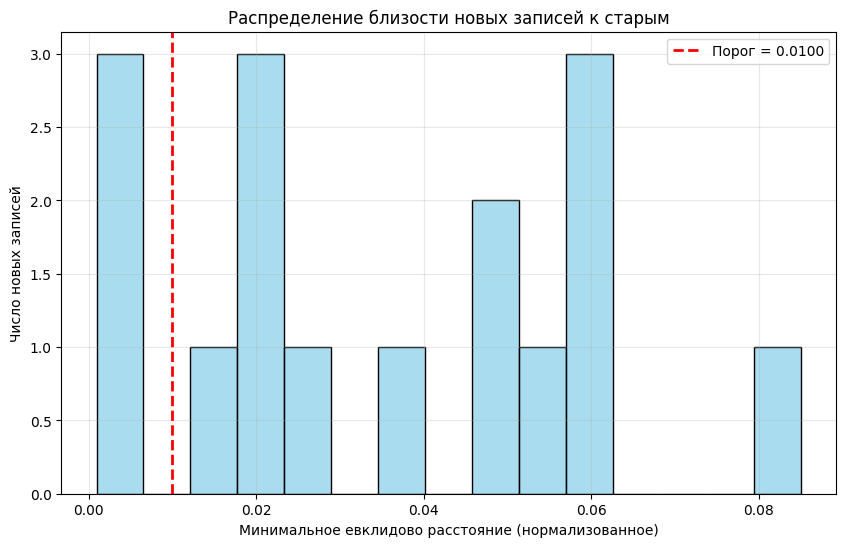

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(min_distances, bins=15, color='skyblue', edgecolor='black', alpha=0.7)

# Добавляем вертикальную линию порога
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Порог = {threshold:.4f}')

plt.xlabel('Минимальное евклидово расстояние (нормализованное)')
plt.ylabel('Число новых записей')
plt.title('Распределение близости новых записей к старым')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

График визуально показал, что условию не удовлетворяют три новых звезды. Обновим датасет и уберем из него, неудовлетворяющие порогу записи.

In [27]:
# Определяем, какие новые записи "слишком близки"
new_indices = df_new.index
too_close_mask = min_distances < threshold

# Находим индексы строк, которые нужно удалить
indices_to_drop = new_indices[too_close_mask]

print(f"Будут удалены строки: {list(indices_to_drop)} (всего: {len(indices_to_drop)})")

# Удаляем из data_extended
data_extended_cleaned = data_extended.drop(index=indices_to_drop).reset_index(drop=True)

print(f"Размер датасета после очистки: {data_extended_cleaned.shape[0]} (было {data_extended.shape[0]})")

Будут удалены строки: [250, 254, 255] (всего: 3)
Размер датасета после очистки: 253 (было 256)


In [28]:
# выведем итоговое распределение звезд по их цвету
data_extended_cleaned['Star color'].value_counts()

Star color
red             112
blue             56
blue_white       41
white            12
yellow_white     12
orange           11
yellow            9
Name: count, dtype: int64

В результате расширения датасета добавлены примеры редких цветовых классов, что улучшило разнообразие по признаку `Star color`.

In [29]:
create_sunburst_plot(data_extended_cleaned)

Диаграмма демонстрирует финальное распределение данных по категориальным признакам. По-прежнему для некоторых типов звезд мы наблюдаем цвет, которому соответствует 1 звезда. Будем считать, что звезды данного цвета для этих типов являются редкостью. Теперь распределение по типу звезд стало менее равномерным: значительно увеличилось количество звезд типа 3. При этом тип 3 стал более сбалансированным по цвету.

Автоматически применен логарифмический масштаб к признакам: ['Luminosity(L/Lo)', 'Radius(R/Ro)']


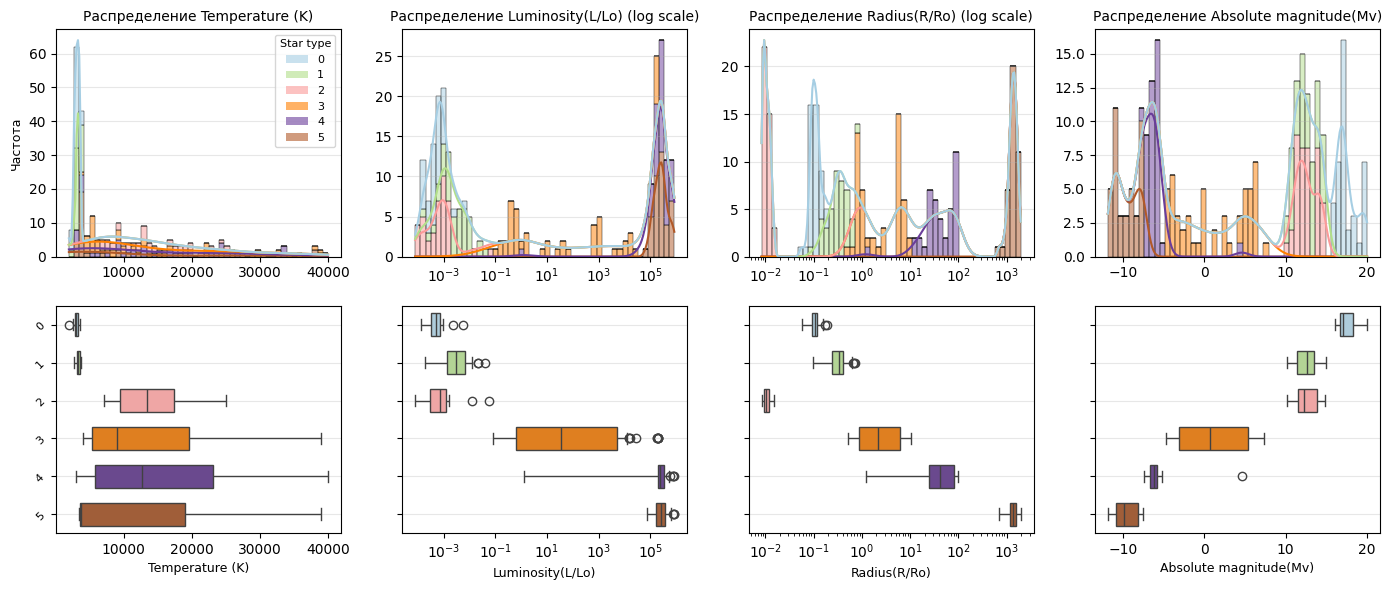

In [30]:
# выберем непрерывные числовые признаки
features = [
    ('Temperature (K)', 'Temperature (K)'),
    ('Luminosity(L/Lo)', 'Luminosity(L/Lo)'),
    ('Radius(R/Ro)', 'Radius(R/Ro)'),
    ('Absolute magnitude(Mv)', 'Absolute magnitude(Mv)')
    ]

plot_distribution_with_boxplot(
    data_extended_cleaned,
    features,
    'Star type',
    #auto_bins=True,
    bins=50,
    log_scale='auto',
)

Диаграммы boxplot демонстрируют характерные зависимости некоторых числовых признаков от типа звезд. Например, рост радиуса с увеличением номера типа звезд за исключением номера 2 (белый карлик). Данное исключение считается нормой: белый карлик по радиусу может быть (и обычно бывает) значительно меньше, чем и красный (1), и коричневый (0) карлик. Абсолютная звёздная величина наоборот уменьшается по мере увеличение номера типа звезды. Что касается относительной светимости, то можно выделить три группы: в первую входят номера типов 0-2, во вторую номер 3, а в третью группу номера 4 и 5. При этом наиболее широкий разброс значений у второй группы, то есть типа звезды под номером 3 (Звёзды главной последовательности). Температура поверхности звезд под номерами 0 и 1 имеет самые маленькие значения и минимальный разброс. В тоже время у остальных типов звезд разброс значений температур достаточно широкий.

**Важный промежуточный вывод на основе представленных диаграмм —** категориальный признак `Star type` является важнейшим признаком, по которому можно сделать оценку того или иного числового признака. Стоит отметить, что для предсказания целевого признака — температуры звезды — данного признака явно недостаточно, так как среди прочего большиство типов звезд имеют широкий разброс температуры.

In [31]:
ordered_colors = [
    'blue',
    'blue_white',
    'white',
    'yellow_white',
    'yellow',
    'orange',
    'red'
]

Автоматически применен логарифмический масштаб к признакам: ['Luminosity(L/Lo)', 'Radius(R/Ro)']


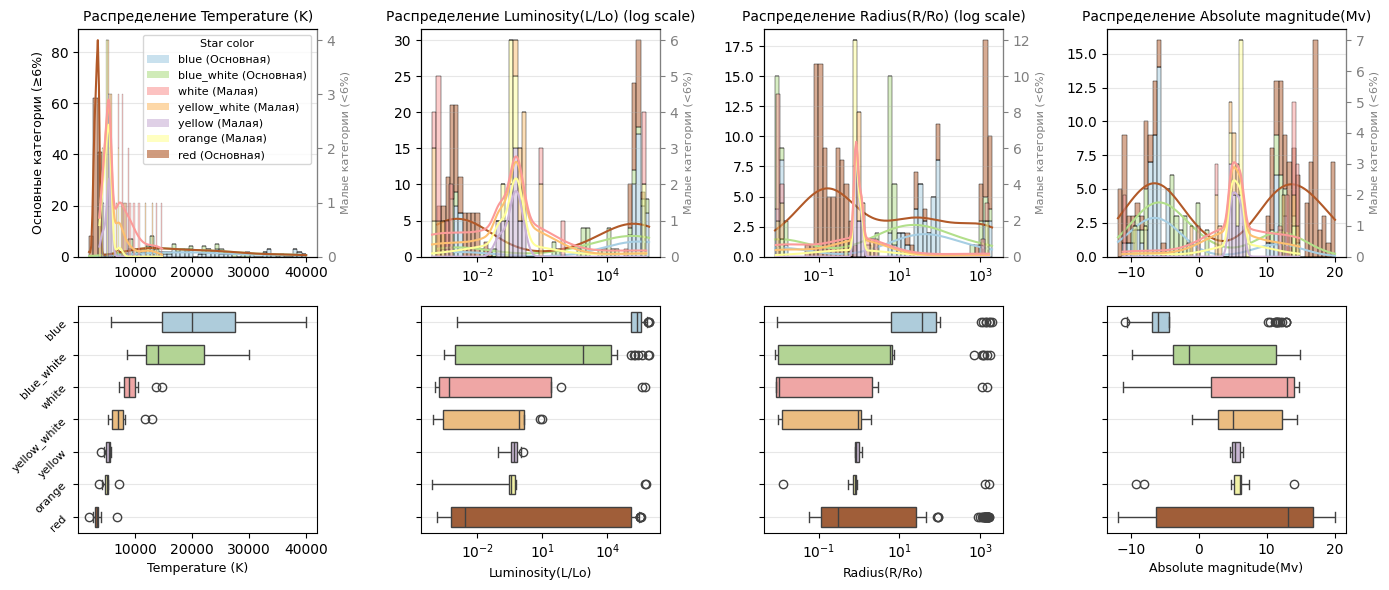

In [32]:
# выберем непрерывные числовые признаки
features = [
    ('Temperature (K)', 'Temperature (K)'),
    ('Luminosity(L/Lo)', 'Luminosity(L/Lo)'),
    ('Radius(R/Ro)', 'Radius(R/Ro)'),
    ('Absolute magnitude(Mv)', 'Absolute magnitude(Mv)')
    ]

plot_distribution_with_boxplot(
    data_extended_cleaned,
    features,
    'Star color',
    category_order=ordered_colors,
    #auto_bins=True,
    minor_category_threshold=0.06,
    bins=50,
    log_scale='auto',
)

Опять же boxplot демонстрирует характерную картину для температуры поверхности звезды и цвета, что логично, поскольку цвет определяется как раз температурой поверхности. Распределения остальных числовых признаков по категориальному признаку `Star color` достаточно сложно трактовать. Для упрощения анализа выделим срезы. С помощью собственной функции `plot_distribution_with_boxplot` установлено, что ряд категорий признака `Star color` имеют ≤6% данных от общего количества. Поэтому можно их выделить в отдельный срез.

In [33]:
cut_less_6_percent = [
    'white',
    'yellow',
    'orange'
]

Автоматически применен логарифмический масштаб к признакам: ['Luminosity(L/Lo)', 'Radius(R/Ro)']


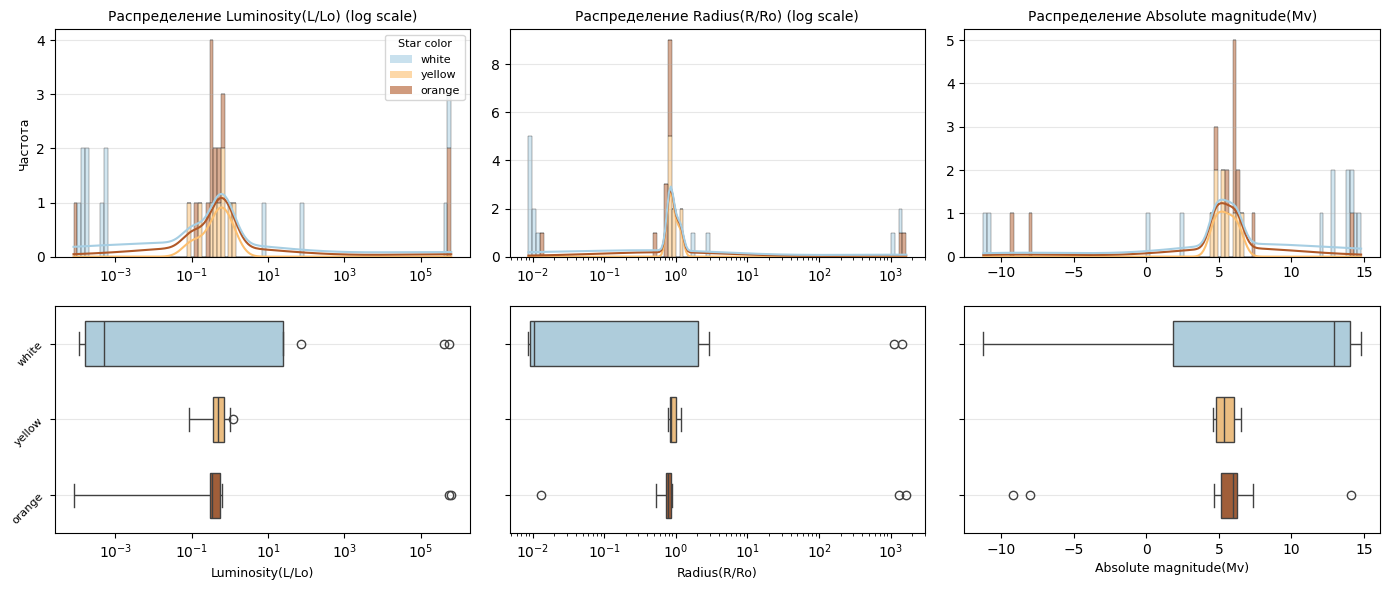

In [34]:
# выберем непрерывные числовые признаки
features = [
    #('Temperature (K)', 'Temperature (K)'),
    ('Luminosity(L/Lo)', 'Luminosity(L/Lo)'),
    ('Radius(R/Ro)', 'Radius(R/Ro)'),
    ('Absolute magnitude(Mv)', 'Absolute magnitude(Mv)')
    ]

plot_distribution_with_boxplot(
    data_extended_cleaned.query('`Star color` in @cut_less_6_percent'),
    features,
    'Star color',
    category_order=cut_less_6_percent,
    bins=100,
    #auto_bins=True,
    log_scale='auto',
)

По срезу малых данных можно сказать, что звезды белого цвета имеют широкий разброс значений числовых признаков относительно других. При этому медианное значение больше, чем для звезд других цветов для признака `Absolute magnitude(Mv)`. И меньше для других рассмотренных здесь числовых признаков. При этому звезды желтого и оранжевого цветов имеют примерно одинаковые диапазоны значений числовых признаков.

In [35]:
cut_greater_6_percent = [
    'blue',
    'blue_white',
    'yellow_white',
    'red'
]

Автоматически применен логарифмический масштаб к признакам: ['Luminosity(L/Lo)', 'Radius(R/Ro)']


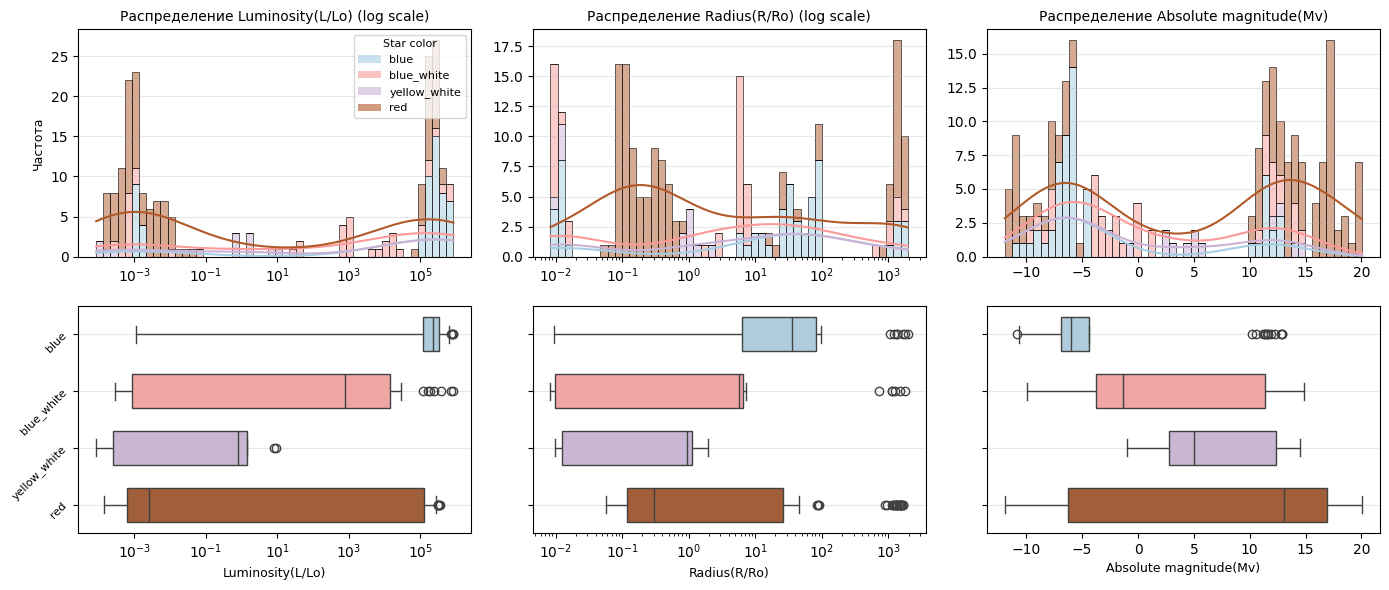

In [36]:
# выберем непрерывные числовые признаки
features = [
    #('Temperature (K)', 'Temperature (K)'),
    ('Luminosity(L/Lo)', 'Luminosity(L/Lo)'),
    ('Radius(R/Ro)', 'Radius(R/Ro)'),
    ('Absolute magnitude(Mv)', 'Absolute magnitude(Mv)')
    ]

plot_distribution_with_boxplot(
    data_extended_cleaned.query('`Star color` in @cut_greater_6_percent'),
    features,
    'Star color',
    category_order=cut_greater_6_percent,
    bins=50,
    #auto_bins=True,
    log_scale='auto',
)

Для категорий, каждая из которых содержит > 6% данных, можно проследить закономерности также и для всех остальных числовых признаков помимо температуры. Если выстроить цвета в порядке уменьшения температуры поверхности звезды, то можно увидеть уменьшение медианных значений относительной светимости, относительного радиуса, а также увеличение медианного значения абсолютной звёздной величины.

**Важный промежуточный вывод на основе представленных диаграмм —** категориальный признак `Star color` является важнейшим признаком, по которому можно сделать оценку того или иного числового признака, особенно целевого признака — температуры поверхности звезды.

**Промежуточные выводы на основе исследовтельского анализа**

1. Датасет расширен, чтобы сделать его более репрезентативным, за счет увеличения количества звезд редких цветов: желтого (+6) и оранжевого (+7).
2. Категориальные признаки являются важными признаками, по которым можно дать оценку того или иного числового признака.
3. Выявлены следующие закономерности.

По типу звезд:
- рост радиуса с увеличением номера типа звезд за исключением номера 2 (белый карлик),
- абсолютная звёздная величина наоборот уменьшается по мере увеличение номера типа звезды

По цвету звезды:
- наблюдается корреляция для температуры поверхности звезды и цвета, что логично, поскольку цвет определяется как раз температурой поверхности.
- для категорий цвета, каждая из которых содержит > 6% данных, можно проследить закономерности также и для всех остальных числовых признаков: если выстроить цвета в порядке уменьшения температуры поверхности звезды, то можно увидеть уменьшение медианных значений относительной светимости, относительного радиуса, а также увеличение медианного значения абсолютной звёздной величины.

## Корреляционный анализ

CPU times: total: 578 ms
Wall time: 633 ms


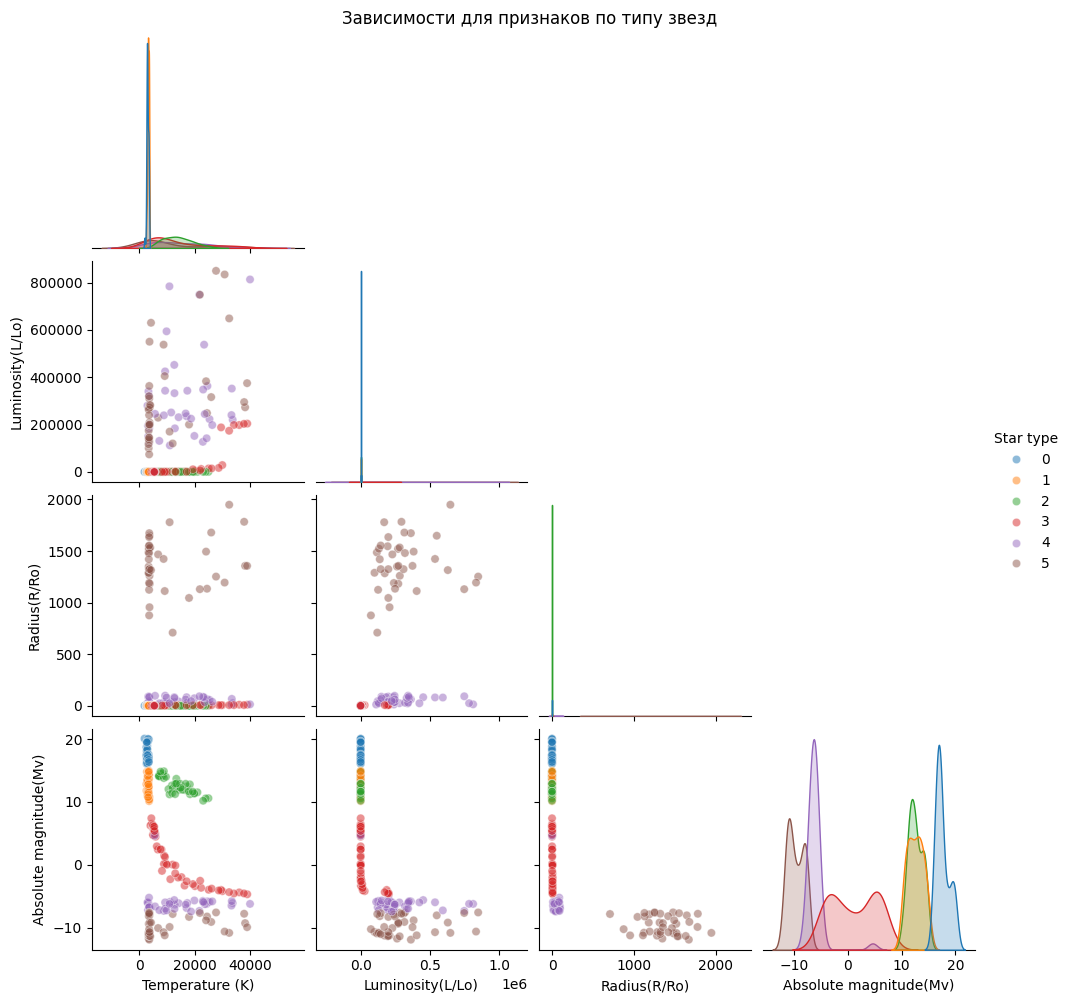

In [37]:
%%time
sns.pairplot(
    data=data_extended_cleaned,
    hue='Star type',        # группировка по классам
    corner=True,         # не рисуем дублирующие графики
    plot_kws={'alpha': 0.5}
).fig.suptitle(
    'Зависимости для признаков по типу звезд',
    y=1.0
);

Матрица рассеяния с разбивкой по типу звезд демонстрирует четко различимые зависимости для каждого типа именно для всех пар признаков с абсолютной звёздной величиной. Также хорошо можно выделить звезду типа `5` на всех зависимостях с относительным радиусом.

CPU times: total: 828 ms
Wall time: 846 ms


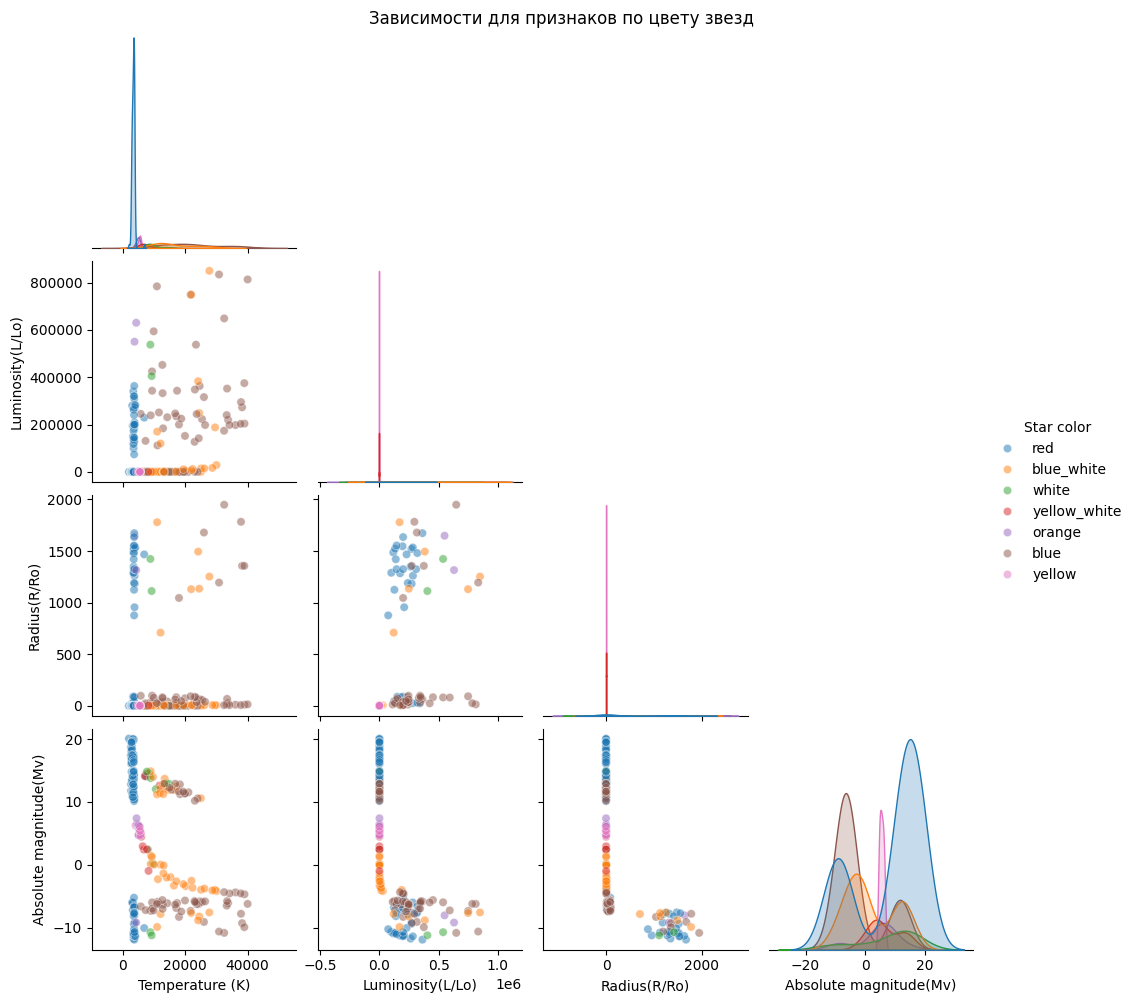

In [38]:
%%time
sns.pairplot(
    data=data_extended_cleaned,
    hue='Star color',        # группировка по классам
    corner=True,         # не рисуем дублирующие графики
    plot_kws={'alpha': 0.5}
).fig.suptitle(
    'Зависимости для признаков по цвету звезд',
    y=1.0
);

Несмотря на большое количество вариантов цветов, которые присутствуют в датасете, можно разглядеть на зависимостях числовых признаков где преимущественно сконцентрированы звезды того или иного цвета.

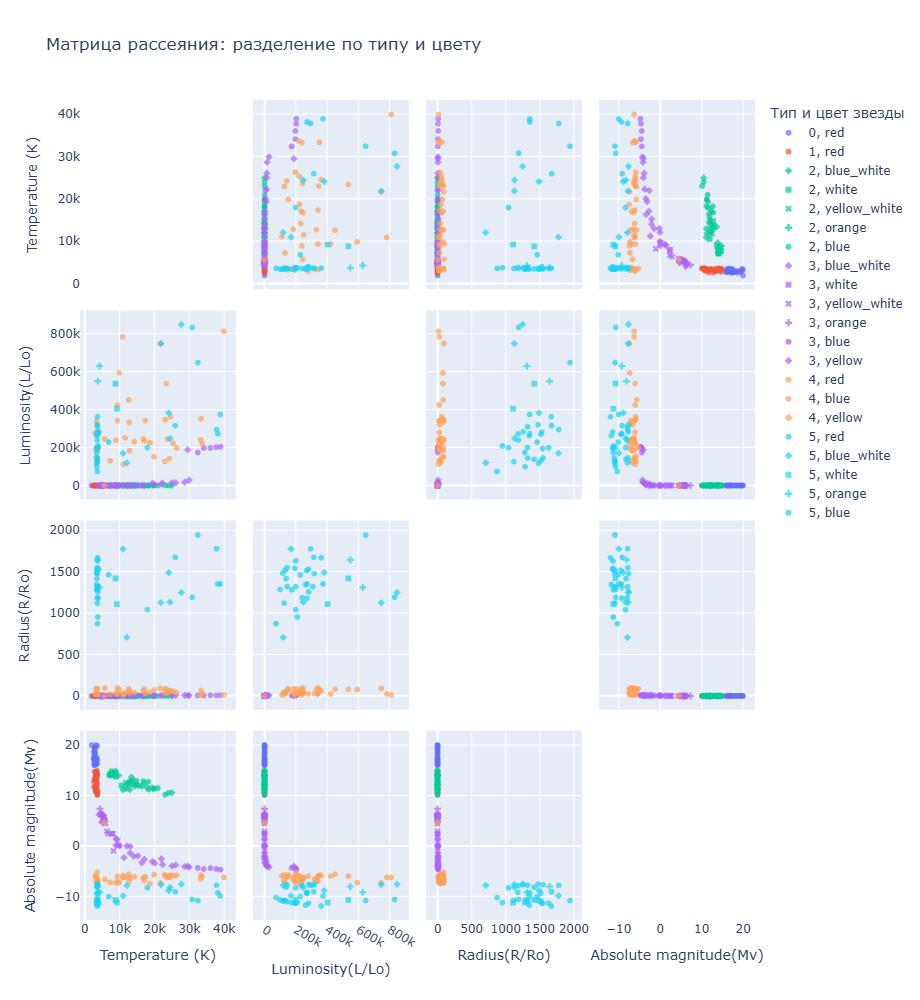

In [39]:
# все типы звезды, с разделением по типу и цвету
fig = px.scatter_matrix(
    data_extended_cleaned,
    dimensions=['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'],
    color='Star type',
    symbol='Star color',
    title='Матрица рассеяния: разделение по типу и цвету',
    opacity=0.7,
    labels={col: col for col in data.columns}
)

fig.update_traces(diagonal_visible=False)
fig.update_layout(width=1000, height=1000, legend_title_text='Тип и цвет звезды')
fig.show()

Матрица рассеяния, построенная с помощью библиотеки `plotly`, позволяет с помощью ручного выбора рассмотреть различные срезы по любой комбинации категориальных признаков, а также быстро увидеть какие цвета присутствуют в том или ином типе звезд.

Поскольку задача разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды, то рассмотрим зависимости температуры от других числовых признаков при разделении на категории более детально.

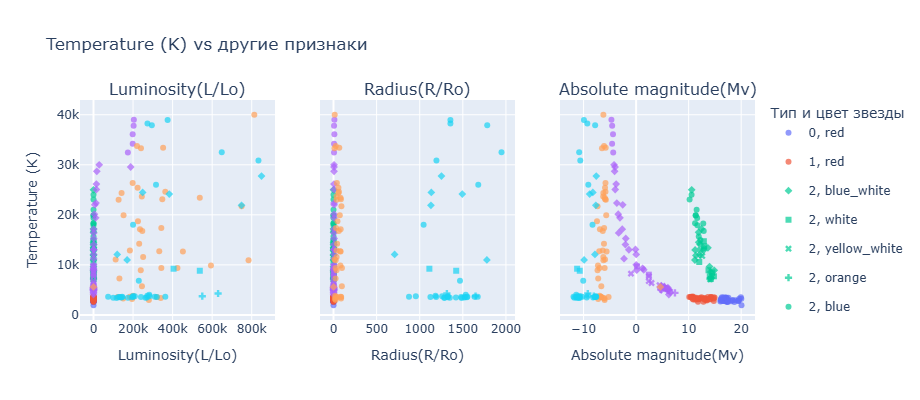

In [40]:
# Определяем признаки, которые будут на оси X (все кроме Temperature)
features = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# Создаем контейнер для 3 графиков в одной строке
fig_first_row = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=features,  # Заголовки для каждого графика
    shared_yaxes=True  # Важно: общая ось Y для всех графиков
)

# Создаем ПЕРВЫЙ scatter plot только для получения правильной структуры легенды
first_scatter = px.scatter(
    data_extended_cleaned,
    x=features[0],  # Первый признак (Luminosity)
    y='Temperature (K)',  # Всегда температура на оси Y
    color='Star type',  # Цвет точек = тип звезды
    symbol='Star color',  # Форма точек = цвет звезды
    opacity=0.7  # Полупрозрачность точек
)

# Создаем множество для отслеживания уже добавленных элементов легенды
legend_added = set()

# Проходим по всем трем признакам для создания графиков
for i, feature in enumerate(features):
    # Для каждого признака создаем отдельный scatter plot
    scatter_fig = px.scatter(
        data_extended_cleaned,
        x=feature,  # Текущий признак на оси X
        y='Temperature (K)',  # Температура на оси Y
        color='Star type',  # Цвет по типу звезды
        symbol='Star color',  # Форма по цвету звезды
        opacity=0.7
    )

    # Проходим по всем traces (группам данных) в созданном графике
    for trace in scatter_fig.data:
        """
        КРИТИЧЕСКИ ВАЖНАЯ ЧАСТЬ: управление легендой
        - Если это ПЕРВЫЙ график (i == 0) И элемент еще не добавлен в легенду
        - Тогда показываем его в легенде (showlegend = True)
        - И добавляем его имя в множество уже добавленных
        - Для всех остальных случаев скрываем из легенды
        """
        if i == 0 and trace.name not in legend_added:
            trace.showlegend = True  # Показывать в легенде
            legend_added.add(trace.name)  # Запоминаем, что добавили
        else:
            trace.showlegend = False  # Скрыть из легенды

        # Добавляем trace в соответствующий subplot
        fig_first_row.add_trace(trace, row=1, col=i+1)

# Настраиваем общий вид графика
fig_first_row.update_layout(
    title='Temperature (K) vs другие признаки',  # Общий заголовок
    width=1200,  # Ширина графика
    height=400   # Высота графика
)

# Настраиваем подписи осей X для каждого subplot
for i, feature in enumerate(features, 1):  # enumerate начинается с 1
    fig_first_row.update_xaxes(
        title_text=feature,  # Подпись оси X = название признака
        row=1,
        col=i  # Номер subplot
    )

# Настраиваем подпись оси Y только для первого subplot
fig_first_row.update_yaxes(
    title_text='Temperature (K)',  # Подпись оси Y
    row=1,
    col=1  # Только для первого графика
)

# Настраиваем размер графика и название легенды
fig_first_row.update_layout(width=1000, legend_title_text='Тип и цвет звезды')

# Показываем итоговый график
fig_first_row.show()

1. Для звезд типа `0` и `1`, которые имеют цвет только `red`, температура меняется в узком диапазоне от 1939К до 3692К по сравнению с другими типами звезд. При этом `Luminosity(L/Lo)` и `Radius(R/Ro)` для типов звезд `0` и `1` меньше 1, а `Luminosity(L/Lo)` преимущественно даже меньше 0.01. Если сравнивать типы звезд `0` и `1` друг с другом, то можно заметить различия: звезды типа `0` имеют меньшие значения `Luminosity(L/Lo)` и `Radius(R/Ro)`, но большие значения `Absolute magnitude(Mv)` от 16 до 20 против от 10 до 15 Mv.
2. Звезды типа `2` по `Luminosity(L/Lo)` расположены вблизи 0 и, не учитывая два выброса, имеют максимальное значение 0.0016. Для таких звезд `Radius(R/Ro)` не превышает 0.015, а `Absolute magnitude(Mv)` варьируется примерно от 10 до 15 Mv.
3. Звезды типа `3` уже имеют `Luminosity(L/Lo)` и `Radius(R/Ro)` значительно превышающие 1 и достигающие 204000 и 10.6 соответственно. Зависимость температуры от `Absolute magnitude(Mv)` имеет вид гиперболы и `Absolute magnitude(Mv)` варьируется примерно от -5.0 до 6.5 Mv. Также уже хорошо просматривается корреляция цвета звезды с температурой и другими числовыми признаками. Так звезды с цветом `blue` для звезд типа `3` имеют большие значения температур, `Luminosity(L/Lo)` и меньшие значения `Absolute magnitude(Mv)`.
4. Для звезд типа `4` корреляция температуры от других числовых признаков практически не просматривается. Для них мы наблюдаем еще больше значения `Luminosity(L/Lo)` и `Radius(R/Ro)`, чем для звезды типа `3`. Максимальные значения: 813000 и 98 соответственно. Звезды типа `4` в датасете имеют преимущественно всего два уникальных цвета `red` и `blue` (плюс одна звезда желтая). Значения `Absolute magnitude(Mv)` преимущественно отрицательные и находятся в узком диапазоне от -7.45 до -5.24 Mv. Наблюдается выброс желтой звезды с `Absolute magnitude(Mv)` равной 4.62.
5. Звезды типа `5` отличаются от типа `4` на порядки большим радиусом с максимальным значением 1948.5, а также еще более отрицательным значением `Absolute magnitude(Mv)`, лежащим в диапазоне от -11.9 до -7.6. Примечательно, что звезды типа `5` имеют преимущественно низкии температуры в районе 3500К.

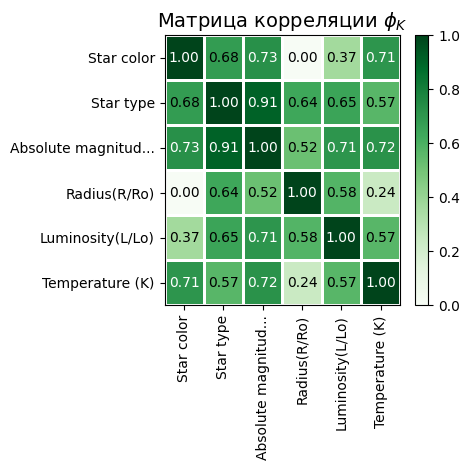

CPU times: total: 281 ms
Wall time: 2.63 s


In [41]:
%%time
# рассчитаем матрицу корреляции Phik
# присвоем переменной correlated_pairs датафрейм с парами признаков и их корреляцией Фи, превышающей порог
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым непрерывным типом данных в обрабатываемом датафрейме
# присвоем переменной phi_k_with_target корреляции признаков с целевой переменной
result = phik_correlation_matrix(
    data_extended_cleaned,
    threshold = 0.9,
    output_interval_cols=True,
    #interval_cols=['purchase_count', 'total_spent', 'avg_purchase_value',
    target_col='Temperature (K)',
    cell_size=0.8
)

# Результаты:
correlated_pairs = result[0]  # Пары коррелирующих признаков
interval_cols = result[1]     # Список числовых непрерывных столбцов
phi_k_with_target = result[2] # Корреляции признаков с целевой переменной

In [42]:
correlated_pairs

признак_1  признак_2  корреляция класс_корреляции
0  Absolute magnitude(Mv)  Star type        0.91    Очень высокая

Наблюдаем мультиколлинеарность у пары признаков `Absolute magnitude(Mv)` и `Star type`. Однако нейронные сети устойчивы к мультиколлинеарности, поэтому в данном проекте это не является критичным. В целом все признаки достаточно хорошо коррелириуют друг с другом, что однозначно положительным образом скажется на предсказательной способности нейронной сети.

Матрица корреляции нам показывает, что максимальная корреляция температуры с цветом звезды, а не ее типом. Поэтому при разделении на тестовую и обучающую выборки для стратификации выберем признак `Star color`.

**Коэффициент инфляции дисперсии (variance inflation factor — VIF)** измеряет насколько сильно дисперсия коэффициента регрессии увеличивается из-за мультиколлинеарности (корреляции с другими признаками). Различают следующие категории мультиколлинеарности по значению VIF:
- вблизи 1 — отсутствует или пренебрежимо слабая;
- больше 5–10 — умеренная или сильная (требует внимания);
- больше 100 — критическая (модель ненадежная).

Опять же, для нейронной сети VIF не является обязательным или критически важным показателем, так как нейросети устойчивы к мультиколлинеарности. Однако иметь представление об избыточности того или иного признака на этапе анализа данных представляется важным.

Используем созданную фукнцию `vif` для расчета коэффициентов инфляции диспресии и рассчитаем их для входных признаков.

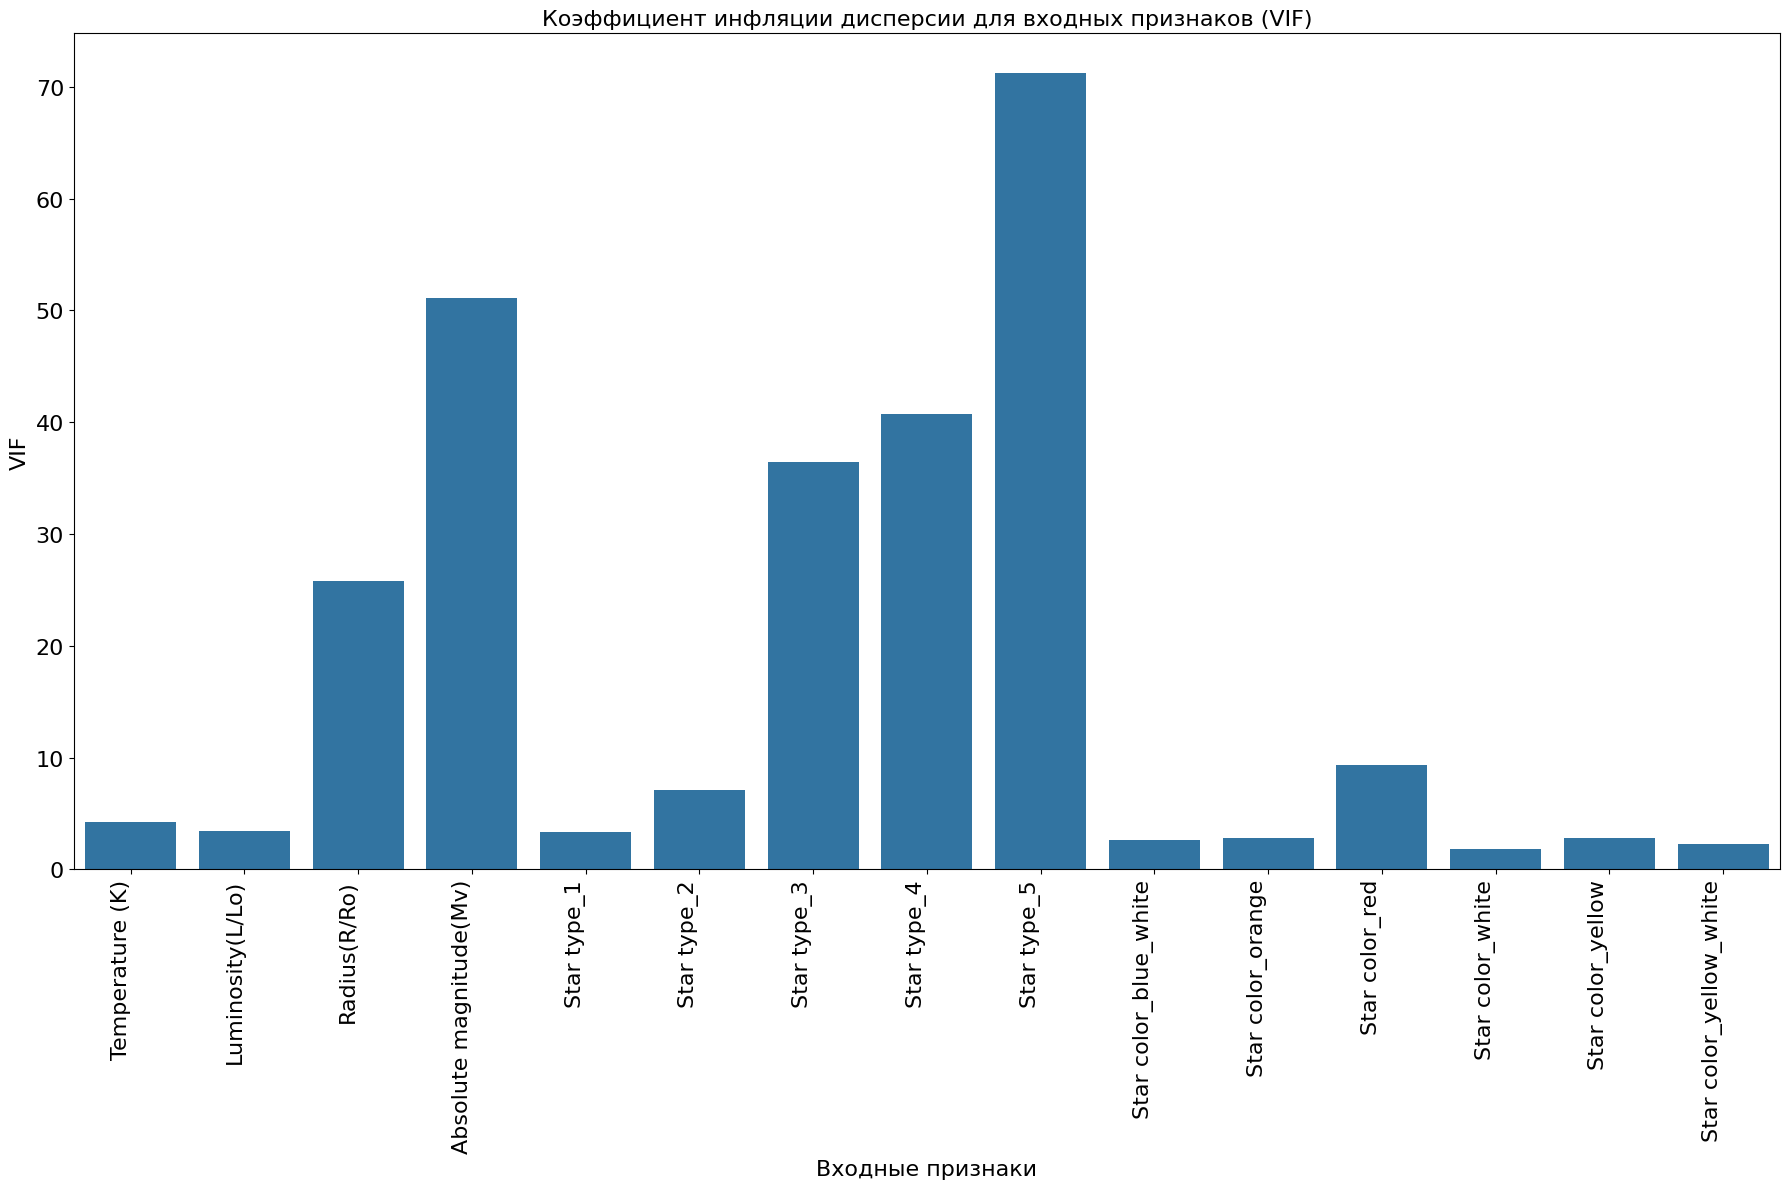

In [43]:
# используем созданную функцию расчета VIF
vif(data_extended_cleaned, font_size=16)

Коэффициенты VIF позволили установить, что тип звезды и `Absolute magnitude(Mv)` дают мультиколлинеарность также в совокупности с другими признаками, что может указывать на их избыточность. Поскольку для нейросети мультиколлинеарность не критична, то попробуем ее создать, используя все данные в датасете.

**Промежуточные выводы на основе корреляционного анализа**

1. Все признаки достаточно хорошо коррелируют друг с другом.
2. Зависимости числовых признаков различаются для звезд разных типов и цветов.
3. Детально рассмотрены зависимости температуры от других числовых признаков при разделении на классы категориальных признаков: выделяется множество закономерностей.
4. Максимальная корреляция температуры с цветом звезды, а не ее типом, поэтому при разделении на тестовую и обучающую выборки для стратификации выберем признак `Star color`.
5. Согласно коэффициентам `VIF` тип звезды и `Absolute magnitude(Mv)` дают мультиколлинеарность в совокупности с другими признаками, что указывает на их избыточность.

## Построение базовой нейронной сети

### Подготовка данных к построению модели

По числовому описанию данных видно, что признаки `Luminosity(L/Lo)` и `Radius(R/Ro)` имеют очень широкий диапазон со сильно смещённым влево пиком на распределении (много малых значений). Логарифмирование поможет уменьшить перекос, сделать распределение ближе к нормальному, уменьшить влияние выбросов.

In [44]:
# делаем копию датафрейма
data_new = data_extended_cleaned.copy()

In [45]:
# Логарифмирование признаков Luminosity(L/Lo) и Radius(R/Ro)
data_new['Luminosity(L/Lo)'] = np.log10(data_extended_cleaned['Luminosity(L/Lo)'])
data_new['Radius(R/Ro)'] = np.log10(data_extended_cleaned['Radius(R/Ro)'])
# Возвращение признаку Star type типа integer
data_new['Star type'] = data_new['Star type'].astype('int')

Проведем разделение на обучающую и тестовую выборки со стратификацией по признаку `Star color`, так как корреляция целевого признака с ним больше, чем с другим категориальным признаком `Star type`, а стратификация с обоими признаками невозможна из-за наличия неделящихся категорий. 

In [46]:
# Разделение данных на признаки и целевую переменную
X = data_new.drop('Temperature (K)', axis=1)
y = data_new['Temperature (K)']

# Разбиваем данные на обучающую и тестовую выборки с сохранением соотношений категорий признака Star color
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=X['Star color']
)

Проведем нормализацию входных данных

In [47]:
# --- Инициализация преобразователей ---
scaler = StandardScaler()
#ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error') # для преобразования категориальных данных (в Яндекс Практикуме) 
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='error') # (на других платформах)

# --- Определяем типы признаков ---
num_features = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'] # числовые
cat_features = ['Star color'] # категориальные

# --- Обучение преобразователей ТОЛЬКО на train ---
X_train_num = X_train[num_features]
X_train_cat = X_train[cat_features]

# Масштабируем числовые признаки
scaled_num_train = scaler.fit_transform(X_train_num)
# Кодируем категориальные признаки
encoded_cat_train = ohe.fit_transform(X_train_cat)

# --- Получаем имена закодированных столбцов ---
#cat_columns = ohe.get_feature_names(cat_features) # (в Яндекс Практикуме)
cat_columns = ohe.get_feature_names_out(cat_features) # (на других платформах)

# --- Преобразуем в DataFrame для удобства ---
scaled_num_train_df = pd.DataFrame(scaled_num_train, columns=num_features, index=X_train.index)
encoded_cat_train_df = pd.DataFrame(encoded_cat_train, columns=cat_columns, index=X_train.index)

# --- Собираем обработанный train ---
X_train_processed = pd.concat([encoded_cat_train_df, scaled_num_train_df, X_train['Star type']], axis=1)

# --- Теперь обрабатываем test ---
X_test_num = X_test[num_features]
X_test_cat = X_test[cat_features]

scaled_num_test = scaler.transform(X_test_num)  
encoded_cat_test = ohe.transform(X_test_cat)    

scaled_num_test_df = pd.DataFrame(scaled_num_test, columns=num_features, index=X_test.index)
encoded_cat_test_df = pd.DataFrame(encoded_cat_test, columns=cat_columns, index=X_test.index)

X_test_processed = pd.concat([encoded_cat_test_df, scaled_num_test_df, X_test['Star type']], axis=1)

In [48]:
# Выведем первые строки признаков в тестовой выборке
X_test_processed.head()

Star color_blue_white  Star color_orange  Star color_red  \
87                     1.0                0.0             0.0   
123                    0.0                0.0             1.0   
161                    0.0                0.0             0.0   
6                      0.0                0.0             1.0   
165                    0.0                0.0             0.0   

     Star color_white  Star color_yellow  Star color_yellow_white  \
87                0.0                0.0                      0.0   
123               0.0                0.0                      0.0   
161               0.0                0.0                      0.0   
6                 0.0                0.0                      0.0   
165               0.0                0.0                      0.0   

     Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  Star type  
87          -1.010111     -1.456211                0.686572          2  
123         -1.189587     -0.831032                1.248196          0  
161          1.198693      0.739290               -1.022313          4  
6           -1.011641     -0.749454                1.277600          0  
165          1.125570      0.632397               -1.117877          4

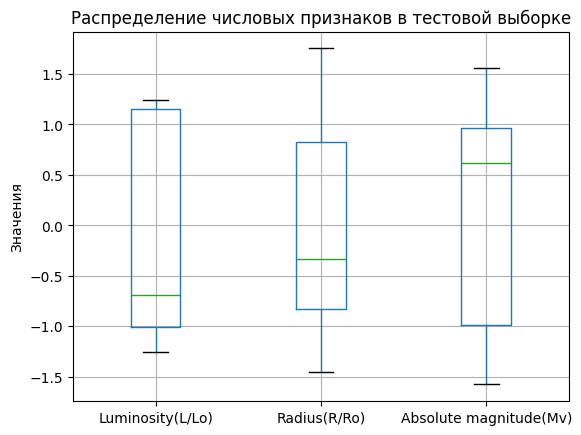

In [49]:
ax = X_test_processed[num_features].boxplot()
ax.set_title('Распределение числовых признаков в тестовой выборке')
ax.set_ylabel('Значения')
plt.show()

Нормализация входных признаков прошла успешно

Проведем нормализацию целевого признака

In [50]:
# Инициализируем scaler для целевой переменной
temp_scaler = StandardScaler()

# Сохраняем в Кельвинах
y_train_true_K = y_train.copy() 
y_test_true_K = y_test.copy()

# Преобразуем y_train и y_test (reshape, так как StandardScaler ожидает 2D)
y_train_2d = y_train.values.reshape(-1, 1)
y_test_2d = y_test.values.reshape(-1, 1)

# Обучаем scaler ТОЛЬКО на y_train и преобразуем train
y_train_scaled = temp_scaler.fit_transform(y_train_2d)

# Преобразуем y_test с помощью уже обученного scaler
y_test_scaled = temp_scaler.transform(y_test_2d)#.flatten()

In [51]:
print("=== СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ ===")
print("\nПОСЛЕ нормализации (y_train_scaled):")
print(f"Среднее: {y_train_scaled.mean():.6f} (должно быть ~0)")
print(f"Стандартное отклонение: {y_train_scaled.std():.6f} (должно быть ~1)")

print("\nПОСЛЕ нормализации (y_test_scaled):")
print(f"Среднее: {y_test_scaled.mean():.6f}")
print(f"Стандартное отклонение: {y_test_scaled.std():.6f}")

=== СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ ===

ПОСЛЕ нормализации (y_train_scaled):
Среднее: 0.000000 (должно быть ~0)
Стандартное отклонение: 1.000000 (должно быть ~1)

ПОСЛЕ нормализации (y_test_scaled):
Среднее: -0.090942
Стандартное отклонение: 0.857342


C:\Users\shaht\AppData\Local\Temp\ipykernel_596\3541119945.py:1: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



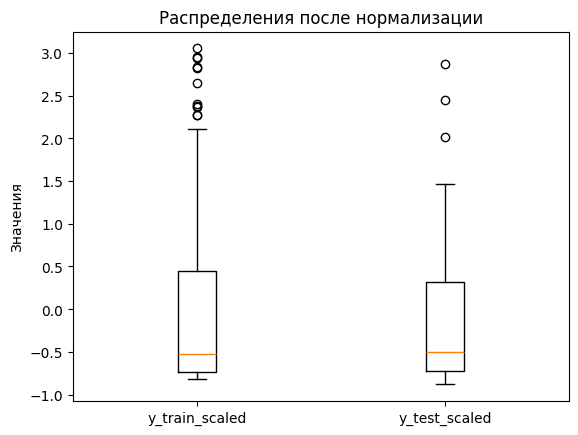

In [52]:
plt.boxplot([y_train_scaled.flatten(), y_test_scaled.flatten()], 
            labels=['y_train_scaled', 'y_test_scaled'])
plt.title('Распределения после нормализации')
plt.ylabel('Значения')
plt.show()

Нормализация целевого признака прошла успешно

### Построение простой модели нейронной сети — baseline

Случайные числа и воспроизводимость

In [53]:
# === Настройка воспроизводимости ===
# Чтобы результаты были одинаковыми при каждом запуске
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)  # Включаем строгую детерминированность

# функция для создания generator ДО каждого DataLoader в цикле
def create_generator():
    g = torch.Generator()
    g.manual_seed(RANDOM_STATE)
    return g

# Если доступен GPU, устанавливаем seed и настройки CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed_all(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True  # Детерминированные алгоритмы в cuDNN
    torch.backends.cudnn.benchmark = False   # Отключаем оптимизацию, которая может нарушить воспроизводимость

In [54]:
# Запрещаем использовать недетерминированные алгоритмы
# Это вызовет ошибку, если где-то используется операция без детерминированной реализации
torch.backends.quantized.engine = "fbgemm"  

Преобразование данных в тензоры

In [55]:
# === Подготовка данных ===
# Преобразуем данные в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train_processed.values)
X_test_tensor = torch.FloatTensor(X_test_processed.values)
y_train_tensor = torch.FloatTensor(y_train_scaled).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test_scaled).reshape(-1, 1)

Создание класса для задания архитектуры нейронной сети

In [56]:
# === Определение нейросетевой модели с Dropout и BatchNorm ===
class NeuralNet(nn.Module):
    """
    Простая полносвязная нейронная сеть с возможностью включения:
    - Dropout (для регуляризации)
    - Batch Normalization (для стабилизации обучения)
    """
    def __init__(self, input_size, hidden_sizes, output_size=1,
                 activation_fn=nn.ReLU(), dropout_rate=0.0, use_batch_norm=False):
        """
        Параметры:
        - input_size: размер входного слоя (количество признаков)
        - hidden_sizes: список с размерами скрытых слоёв, например [64, 32]
        - output_size: размер выходного слоя (для регрессии = 1)
        - activation_fn: функция активации (по умолчанию ReLU)
        - dropout_rate: вероятность отключения нейронов (0.0 = отключено)
        - use_batch_norm: использовать ли BatchNorm1d после линейных слоёв
        """
        super(NeuralNet, self).__init__()
        layers = []  # Список слоёв, из которых будет собрана сеть
        in_features = input_size  # Размер входа текущего слоя

        # Проходим по каждому скрытому слою
        for hidden_size in hidden_sizes:
            # 1. Линейный слой
            layers.append(nn.Linear(in_features, hidden_size))

            # 2. Batch Normalization (опционально)
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))

            # 3. Активация
            layers.append(activation_fn)

            # 4. Dropout (опционально)
            if dropout_rate > 0.0:
                layers.append(nn.Dropout(dropout_rate))

            # Обновляем размер входа для следующего слоя
            in_features = hidden_size

        # Выходной слой (без активации — для регрессии)
        layers.append(nn.Linear(in_features, output_size))

        # Собираем все слои в последовательную сеть
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """Прямой проход через сеть"""
        return self.network(x)

Создание функции для обучения нейронной сети

In [57]:
# === Функция обучения модели с early stopping ===
def train_model(
    # === Архитектура модели ===
    input_size,
    hidden_sizes,
    activation_fn=nn.ReLU(),
    dropout_rate=0.0,
    use_batch_norm=False,

    # === Гиперпараметры обучения ===
    learning_rate=1e-3,
    optimizer_name='adam',  # 'adam', 'adamw', 'sgd'
    batch_size=BATCH_SIZE,
    accumulation_steps=ACCUMULATION_STEPS,

    # === Данные ===
    X_train=None,
    y_train=None,
    X_test=None,
    y_test=None,

    # === Прочие параметры ===
    num_epochs=NUM_EPOCHS,
    print_every=PRINT_EVERY,
    patience=PATIENCE,
    device=None,
    loss_fn=None
):

    """
    Обучает модель с использованием DataLoader и early stopping.
    Поддерживает градиентный аккумулятор и BatchNorm при малых batch.

    Полностью автономная функция обучения:
    - создаёт модель и оптимизатор сама,
    - переносит всё на device,
    - поддерживает grid search по lr, optimizer, batch_size и accumulation_steps.

    Возвращает:
    - обученную модель (с лучшими весами)
    - историю метрик
    - лучшее значение Test RMSE
    - номер последней выполненной эпохи
    - среднее время одной эпохи (в секундах)
    """

    # --- Подготовка: Определяем устройство (CPU или GPU) ---
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # --- Создаём модель ---
    model = NeuralNet(
        input_size=input_size,
        hidden_sizes=hidden_sizes,
        activation_fn=activation_fn,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    
    
    # === ИНИЦИАЛИЗАЦИЯ ВЕСОВ ===
    def init_weights(m):
        if isinstance(m, nn.Linear):
            # Определяем nonlinearity для Kaiming
            if isinstance(activation_fn, (nn.ReLU, nn.ReLU6)):
                nonlinearity = 'relu'
                a = 0.0
            elif isinstance(activation_fn, nn.LeakyReLU):
                nonlinearity = 'leaky_relu'
                a = activation_fn.negative_slope  # например, 0.01
            else:
                # По умолчанию — 'relu' для GELU, SiLU и др.
                nonlinearity = 'relu'
                a = 0.0

            # Kaiming normal initialization
            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity=nonlinearity, a=a)
            if m.bias is not None:
                init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm1d):
            init.ones_(m.weight)
            init.zeros_(m.bias)

    # Применяем инициализацию
    model.apply(init_weights)
    # === КОНЕЦ ИНИЦИАЛИЗАЦИИ ===


    # --- Создаём оптимизатор ---
    if optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Неизвестный оптимизатор: {optimizer_name}")

    # --- Переносим данные на устройство ---
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # --- DataLoader с drop_last=True — чтобы избежать batch_size=1 ---
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        generator=create_generator()
    )
    num_batches = len(train_loader)

    # --- Early stopping ---
    wait = 0
    best_test_rmse = float('inf') # Лучший результат на тесте
    best_model_state = None # Сохраняем лучшие веса
    is_overfitting = False # Флаг переобучения

    # --- Начальная ошибка ---
    model.eval() # режим предсказания
    with torch.no_grad():
        initial_train_rmse = torch.sqrt(loss_fn(model(X_train), y_train)).item()
    print(f"\nНачальный Train RMSE: {initial_train_rmse:.4f}")

    # --- История и время ---
    history = {'epoch': [], 'train_rmse': [], 'test_rmse': []}
    epoch_times = []

    # --- Обучение ---
    for epoch in range(num_epochs):
        start_time = time.time() # Замер времени начала эпохи
        model.train()
        optimizer.zero_grad()

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            # Прямой проход
            preds = model(X_batch)
            loss_value = loss_fn(preds, y_batch)
            # Обратное распространение (с аккумуляцией градиентов)
            (loss_value / accumulation_steps).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == num_batches:
                optimizer.step()
                optimizer.zero_grad()

        # --- Логирование ---
        # Конец эпохи — замер времени
        end_time = time.time()
        epoch_duration = end_time - start_time
        epoch_times.append(epoch_duration)

         # Логирование каждые print_every эпох
        if epoch % print_every == 0:
            model.eval()
            with torch.no_grad():
                # Полные проходы по train и test
                train_rmse = torch.sqrt(loss_fn(model(X_train), y_train)).item()
                test_rmse = torch.sqrt(loss_fn(model(X_test), y_test)).item()

            # Сохраняем в историю
            history['epoch'].append(epoch)
            history['train_rmse'].append(train_rmse)
            history['test_rmse'].append(test_rmse)

            # Выводим метрики и время эпохи
            avg_time = sum(epoch_times) / len(epoch_times)
            print(
                f"Epoch {epoch:4d}/{num_epochs} | Train RMSE: {train_rmse:.4f} | "
                f"Test RMSE: {test_rmse:.4f} | Δ: {train_rmse - test_rmse:+.4f} | "
                f"Time: {epoch_duration:.2f}s (avg: {avg_time:.2f}s)"
            )

            # Проверка улучшения на тесте
            if test_rmse < best_test_rmse:
                best_test_rmse = test_rmse
                wait = 0
                best_model_state = model.state_dict().copy()  # Сохраняем лучшие веса
                is_overfitting = False
            else:
                wait += 1
                # Эвристика: если тестовая ошибка растёт, а обучающая падает — переобучение
                if epoch >= 2 * print_every:
                    if test_rmse > 1.1 * train_rmse and train_rmse < 0.7 * initial_train_rmse:
                        is_overfitting = True

            # Early stopping: если нет улучшений patience*print_every эпох
            if wait >= patience:
                print(f"\n🛑 Early stopping на эпохе {epoch}")
                print(f"Лучший Test RMSE: {best_test_rmse:.4f}")
                if is_overfitting:
                    print("❗ Переобучение")
                else:
                    print("❗ Нет улучшений")
                break

    # --- Восстановление лучшей модели ---
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("✅ Лучшая модель восстановлена")

    final_epoch = epoch # Номер последней выполненной эпохи
    avg_time_per_epoch = sum(epoch_times) / len(epoch_times) # Среднее время одной эпохи


    return model, history, best_test_rmse, final_epoch, avg_time_per_epoch  

Определение архитектур для сравнения. Ниже в ячейке типа `Raw` представлен список словарей с уже обученными разными архитектурами. Делаю тип `Raw` для уменьшения времени выполнения Юпитер тетрадки. Результаты сравнения сведены в датафрейм `arch_data_df`, который представлен далее.

In [58]:
# Будем тестировать разные комбинации:
# - различные активации
# - с/без Dropout
# - с/без BatchNorm
# - разное количество слоев
# - разное количество нейронов
architectures = [
    {
        'name': 'Small ReLU',
        'hidden_sizes': [32, 16],
        'activation': nn.ReLU(),
        'dropout_rate': 0.0,
        'use_batch_norm': False
    },
    {
        'name': 'Small ReLU + Dropout 0.2',
        'hidden_sizes': [32, 16],
        'activation': nn.ReLU(),
        'dropout_rate': 0.2,
        'use_batch_norm': False
    },
    {
        'name': 'Small ReLU + BatchNorm',
        'hidden_sizes': [32, 16],
        'activation': nn.ReLU(),
        'dropout_rate': 0.0,
        'use_batch_norm': True
    },
    {
        'name': 'Small ReLU + Dropout 0.2 + BatchNorm',
        'hidden_sizes': [32, 16],
        'activation': nn.ReLU(),
        'dropout_rate': 0.2,
        'use_batch_norm': True
    },
    {
        'name': 'Deep + BatchNorm',
        'hidden_sizes': [64, 32, 32, 16],
        'activation': nn.ReLU(),
        'dropout_rate': 0.0,
        'use_batch_norm': True
    },
    {
        'name': 'Tanh + BatchNorm',
        'hidden_sizes': [32, 16],
        'activation': nn.Tanh(),
        'dropout_rate': 0.0,
        'use_batch_norm': True
    }
]

In [59]:
# === Настройка обучения ===
input_size = X_train_processed.shape[1]          # Количество признаков
loss_fn = nn.MSELoss()                 # Функция потерь (MSE для регрессии)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Автоопределение устройства

# Список для хранения результатов
results = []

In [60]:
%%time

# === Обучение каждой архитектуры ===
for arch in architectures:
    print(f"\n" + "="*60)
    print(f"Обучение модели: {arch['name']}")
    print(f"Архитектура: {arch['hidden_sizes']}, Dropout: {arch['dropout_rate']}, "
          f"BatchNorm: {'Да' if arch['use_batch_norm'] else 'Нет'}, Активация: {arch['activation'].__class__.__name__}")
    print("="*60)

    # ВЫЗЫВАЕМ train_model с параметрами для создания модели внутри
    trained_model, history, best_test_rmse, final_epoch, avg_time_per_epoch = train_model(
        # === Параметры архитектуры ===
        input_size=input_size,
        hidden_sizes=arch['hidden_sizes'],
        activation_fn=arch['activation'],
        dropout_rate=arch['dropout_rate'],
        use_batch_norm=arch['use_batch_norm'],

        # === Гиперпараметры обучения ===
        learning_rate=1e-3,
        optimizer_name='adam',
        batch_size=BATCH_SIZE,
        accumulation_steps=ACCUMULATION_STEPS,

        # === Данные ===
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        X_test=X_test_tensor,
        y_test=y_test_tensor,

        # === Прочие параметры ===
        num_epochs=NUM_EPOCHS,
        print_every=PRINT_EVERY,
        patience=PATIENCE,
        device=device,
        loss_fn=nn.MSELoss()
    )

    # Сохраняем результаты
    results.append({
        'name': arch['name'],
        'model': trained_model,
        'best_test_rmse': best_test_rmse,
        'history': history,
        'dropout_rate': arch['dropout_rate'],
        'use_batch_norm': arch['use_batch_norm'],
        'final_epoch': final_epoch,
        'avg_time_per_epoch': avg_time_per_epoch
    })

    print(f"✅ Завершено: {arch['name']} | Test RMSE: {best_test_rmse:.4f}")


Обучение модели: Small ReLU
Архитектура: [32, 16], Dropout: 0.0, BatchNorm: Нет, Активация: ReLU

Начальный Train RMSE: 1.3316
Epoch    0/10000 | Train RMSE: 1.2251 | Test RMSE: 1.0171 | Δ: +0.2080 | Time: 0.02s (avg: 0.02s)
Epoch  100/10000 | Train RMSE: 0.5249 | Test RMSE: 0.5036 | Δ: +0.0213 | Time: 0.00s (avg: 0.00s)
Epoch  200/10000 | Train RMSE: 0.4915 | Test RMSE: 0.5162 | Δ: -0.0247 | Time: 0.00s (avg: 0.00s)
Epoch  300/10000 | Train RMSE: 0.4789 | Test RMSE: 0.5160 | Δ: -0.0371 | Time: 0.00s (avg: 0.00s)
Epoch  400/10000 | Train RMSE: 0.4694 | Test RMSE: 0.5045 | Δ: -0.0351 | Time: 0.00s (avg: 0.00s)
Epoch  500/10000 | Train RMSE: 0.4622 | Test RMSE: 0.4876 | Δ: -0.0254 | Time: 0.00s (avg: 0.00s)
Epoch  600/10000 | Train RMSE: 0.4553 | Test RMSE: 0.4875 | Δ: -0.0322 | Time: 0.00s (avg: 0.00s)
Epoch  700/10000 | Train RMSE: 0.4530 | Test RMSE: 0.4782 | Δ: -0.0252 | Time: 0.00s (avg: 0.00s)
Epoch  800/10000 | Train RMSE: 0.4502 | Test RMSE: 0.5077 | Δ: -0.0575 | Time: 0.00s (av

In [61]:
# === Создаём таблицу результатов ===
df_results = pd.DataFrame([
    {
        'Архитектура': res['name'],
        'Dropout': res['dropout_rate'],
        'BatchNorm': 'Да' if res['use_batch_norm'] else 'Нет',
        'Эпох': res['final_epoch'],
        'Среднее время эпохи, сек': res['avg_time_per_epoch'],
        'Test RMSE': res['best_test_rmse']
    }
    for res in results
])

# Сортируем по Test RMSE (от меньшего к большему)
df_results = df_results.sort_values(by='Test RMSE').reset_index(drop=True)

# Лучшая модель
best_model = min(results, key=lambda x: x['best_test_rmse'])['model']
best_result = df_results.iloc[0]  # первая строка — лучшая модель по test RMSE
display(df_results)
print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_result['Архитектура']}")
print(f"Test RMSE: {best_result['Test RMSE']:.4f}")
print('Находится в переменной best_model')

Архитектура  Dropout BatchNorm  Эпох  \
0                      Deep + BatchNorm      0.0        Да  1300   
1                      Tanh + BatchNorm      0.0        Да  2000   
2  Small ReLU + Dropout 0.2 + BatchNorm      0.2        Да  1600   
3                Small ReLU + BatchNorm      0.0        Да  1400   
4              Small ReLU + Dropout 0.2      0.2       Нет  3300   
5                            Small ReLU      0.0       Нет  1200   

   Среднее время эпохи, сек  Test RMSE  
0                  0.009234   0.338679  
1                  0.005859   0.360564  
2                  0.006628   0.361176  
3                  0.006079   0.369175  
4                  0.003059   0.373727  
5                  0.002879   0.478207


ЛУЧШАЯ МОДЕЛЬ: Deep + BatchNorm
Test RMSE: 0.3387
Находится в переменной best_model


По результатам исследования разных архитектур видно, что лучшей по метрике `RMSE` является `Deep + BatchNorm`. Ее и будем использовать для улучшения.

При этом архитектура `Small ReLU + Dropout 0.2 + BatchNorm` оказалась лучше, чем `Small ReLU + BatchNorm` и `Small ReLU + Dropout 0.2`, что как я понимаю является не стандартной ситуацией, так как принято считать, что совместное использование `Dropout` и `BatchNorm` уступает архитектурам с одним из этих методов. Возможно низкое значение параметра `Dropout` дает слабый эффект при совместном использовании.

Трём архитектурам `Small ReLU`, `Small ReLU + Dropout 0.2`, `Tanh + BatchNorm` не хватило 10000 эпох для сходимости, однако для двух из них, учитывая среднее время эпохи, общее время обучения будет значительно больше, чем для трех лидирующих по RMSE архитектур, а архитектура `Small ReLU` более простая и вероятно не даст значительно лучших метрик даже при большем количестве эпох.

Среди трех лидирующих по RMSE архитектур можно еще отметить `Small ReLU + BatchNorm` как самую быструю среди них. И если рассматривать время обучения как более важную метрику, чем RMSE, то можно отдать предпочтение именно архитектуре `Small ReLU + BatchNorm`.

Построим график «Факт — Прогноз» для тестовой выборки, где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной —
температура в Кельвинах.

In [62]:
# Функция для RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

Модель находится на: cpu
RMSE = 3657.961 K


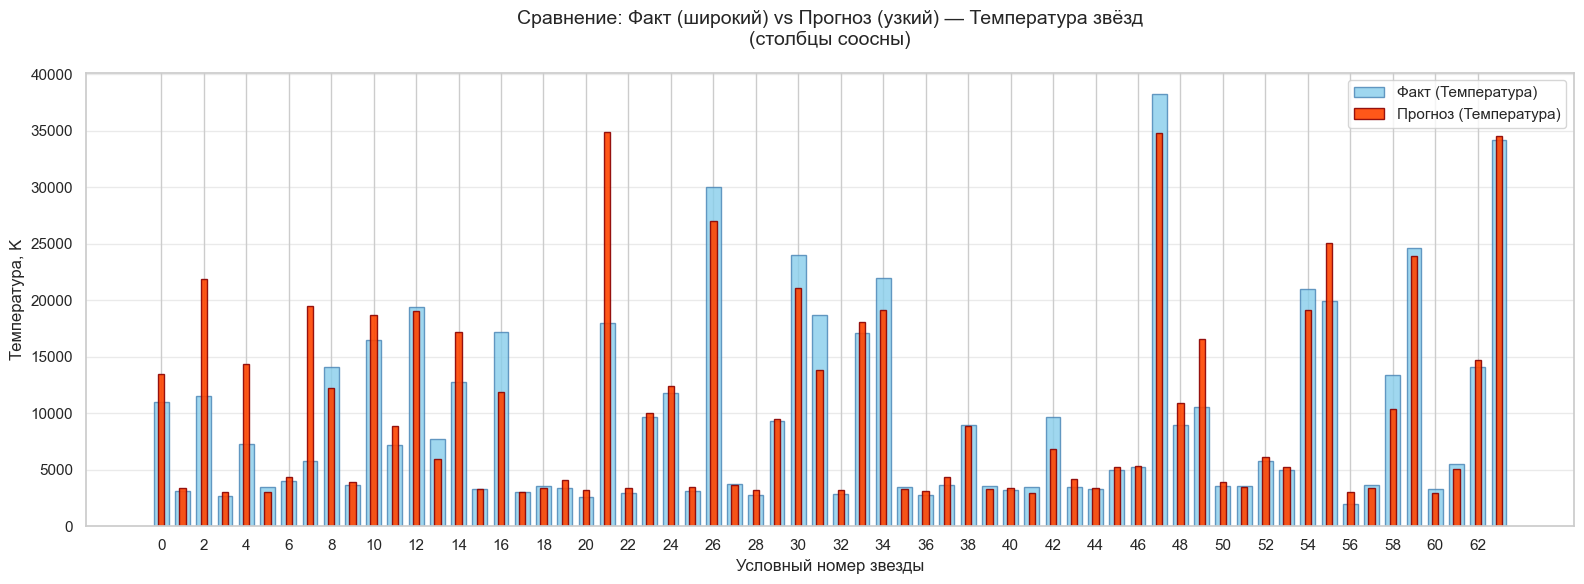

In [63]:
# Устанавливаем стиль seaborn
sns.set_theme(style="whitegrid")

# Определяем устройство модели (или используем глобальное device)
device = next(best_model.parameters()).device  # Узнаём, где модель: CPU или CUDA
print(f"Модель находится на: {device}")

# Переводим модель в режим оценки
best_model.eval()

# Переносим данные на то же устройство, где модель
X_test_tensor_device = X_test_tensor.to(device)
y_test_tensor_device = y_test_tensor.to(device)  # тоже для согласованности

# Получаем предсказания
with torch.no_grad():
    y_pred_tensor = best_model(X_test_tensor_device)

# Преобразуем в numpy (для этого нужно перевести на CPU)
y_test_np = y_test_true_K
y_pred_np_1 = temp_scaler.inverse_transform(y_pred_tensor.cpu().numpy()).flatten()

# Рассчитываем RMSE в Кельвинах
rmse_1 = rmse(y_test_np, y_pred_np_1)
print(f"RMSE = {rmse_1:.3f} K")

# Условные номера звёзд
indices = np.arange(len(y_test_np))

# Ширина столбцов
width_fact = 0.7  # Широкий
width_pred = 0.3  # Узкий

# Создаём график
plt.figure(figsize=(16, 6))

# Добавляем столбцы: оба центрированы по одной и той же координате
plt.bar(indices, y_test_np, width=width_fact, color='skyblue', label='Факт (Температура)', alpha=0.8, edgecolor='steelblue', linewidth=1)
plt.bar(indices, y_pred_np_1, width=width_pred, color='orangered', label='Прогноз (Температура)', alpha=0.9, edgecolor='darkred', linewidth=1)

# Оформление
plt.title('Сравнение: Факт (широкий) vs Прогноз (узкий) — Температура звёзд\n(столбцы соосны)', fontsize=14, pad=20)
plt.xlabel('Условный номер звезды', fontsize=12)
plt.ylabel('Температура, K', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, axis='y', alpha=0.4)

# Улучшаем ось X: не перегружаем метки
if len(indices) > 20:
    plt.xticks(indices[::2])  # Каждую вторую метку
else:
    plt.xticks(indices)

plt.tight_layout()
plt.show()

Согласно графику «Факт — Прогноз» видно, что для звезд с низкими температурами до 5000 К абсолютная ошибка прогноза меньше, чем для звезд с высокими температурами. Правда наблюдаются звезды, прогноз для которых значительно превышает фактическое значение, например, звезда под номером 59 имеет ошибку более чем в два раза больше, чем фактическое значение температуры для этой звезды.

**Промежуточные выводы по baseline**

1. По результатам исследования выбрана архитектура `Deep + BatchNorm`, так как нейронная сеть с ней демонстрирует самую низкую метрику RMSE.
2. Baseline нейронная сеть демонстрирует RMSE = 3905, что сразу меньше требуемого по заданию (4500).
3. График «Факт — Прогноз» указывает на более точные предсказания нейросети для звезд с температурами меньше 5000 К, при этом для звезд с температурой больше 5000 К относительное отклонение прогноза может быть больше 100%.

## Улучшение нейронной сети

Функция эксперимента (с фиксированной архитектурой)

In [64]:
# Для удобства создадим отдельную функцию эксперимента на основе функции обучения
def run_experiment_fixed_arch(batch_size, learning_rate):
    """
    Обучает модель с фиксированной архитектурой, варьируя только batch_size и lr
    """
    # Вызываем train_model с фиксированными параметрами архитектуры как в лучшей модели
    trained_model, history, best_test_rmse, final_epoch, avg_epoch_time = train_model(
        # === Фиксированная архитектура ===
        input_size=input_size,
        hidden_sizes=[64, 32, 32, 16],
        activation_fn=nn.ReLU(),
        dropout_rate=0.0,
        use_batch_norm=True,

        # === Варьируемые гиперпараметры ===
        learning_rate=learning_rate,
        batch_size=batch_size,

        # === Фиксированные параметры обучения ===
        optimizer_name='adam',
        accumulation_steps=ACCUMULATION_STEPS,
        num_epochs=NUM_EPOCHS,
        print_every=PRINT_EVERY,
        patience=PATIENCE,

        # === Данные ===
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        X_test=X_test_tensor,
        y_test=y_test_tensor,

        # === Прочие параметры ===
        device=device
    )

    return {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'best_test_rmse': best_test_rmse,
        'final_epoch': final_epoch,
        'avg_epoch_time': avg_epoch_time,
        'history': history,
        'best_model_state_dict': trained_model.state_dict()
    }

Определим сетку гиперпараметров

In [65]:
# Сетка: только batch_size и learning_rate
param_grid = {
    'batch_size': [8, 16, 64],
    'learning_rate': [1e-4, 5e-4, 2e-3]
}

# Генерируем комбинации
keys = param_grid.keys()
values = param_grid.values()
combinations = [dict(zip(keys, v)) for v in product(*values)]

Запуск GridSearch

In [66]:
%%time

print(f"Запуск {len(combinations)} экспериментов...")
print(f"""Фиксированные параметры:
  hidden_sizes = [64, 32, 32, 16]
  activation   = nn.ReLU()
  dropout      = 0.0
  batch_norm   = True
  optimizer    = Adam
  accumulation_steps = {ACCUMULATION_STEPS}""")
print(f"Используемое устройство: {device}")

results = []

for params in tqdm(combinations, desc="GridSearch"):
    try:
        result = run_experiment_fixed_arch(
            batch_size=params['batch_size'],
            learning_rate=params['learning_rate']
        )
        results.append(result)

        # Вывод промежуточных результатов
        print(f"BS: {params['batch_size']:2d}, LR: {params['learning_rate']:.1e}, "
              f"Test RMSE: {result['best_test_rmse']:.4f}, "
              f"Epochs: {result['final_epoch']}, Time: {result['avg_epoch_time']:.3f}s")

    except Exception as e:
        print(f"❌ Ошибка для параметров {params}: {e}")
        continue

Запуск 9 экспериментов...
Фиксированные параметры:
  hidden_sizes = [64, 32, 32, 16]
  activation   = nn.ReLU()
  dropout      = 0.0
  batch_norm   = True
  optimizer    = Adam
  accumulation_steps = 2
Используемое устройство: cpu


GridSearch:   0%|                                                                                | 0/9 [00:00<?, ?it/s]


Начальный Train RMSE: 7.5136
Epoch    0/10000 | Train RMSE: 1.8040 | Test RMSE: 1.7622 | Δ: +0.0417 | Time: 0.04s (avg: 0.04s)
Epoch  100/10000 | Train RMSE: 0.5284 | Test RMSE: 0.5339 | Δ: -0.0055 | Time: 0.03s (avg: 0.03s)
Epoch  200/10000 | Train RMSE: 0.4696 | Test RMSE: 0.4530 | Δ: +0.0167 | Time: 0.04s (avg: 0.03s)
Epoch  300/10000 | Train RMSE: 0.4413 | Test RMSE: 0.4189 | Δ: +0.0224 | Time: 0.03s (avg: 0.03s)
Epoch  400/10000 | Train RMSE: 0.4265 | Test RMSE: 0.4488 | Δ: -0.0223 | Time: 0.03s (avg: 0.03s)
Epoch  500/10000 | Train RMSE: 0.4208 | Test RMSE: 0.3980 | Δ: +0.0228 | Time: 0.03s (avg: 0.03s)
Epoch  600/10000 | Train RMSE: 0.4016 | Test RMSE: 0.3958 | Δ: +0.0058 | Time: 0.03s (avg: 0.03s)
Epoch  700/10000 | Train RMSE: 0.4118 | Test RMSE: 0.3975 | Δ: +0.0143 | Time: 0.03s (avg: 0.03s)
Epoch  800/10000 | Train RMSE: 0.4229 | Test RMSE: 0.3722 | Δ: +0.0507 | Time: 0.03s (avg: 0.03s)
Epoch  900/10000 | Train RMSE: 0.3942 | Test RMSE: 0.3648 | Δ: +0.0294 | Time: 0.03s (av

GridSearch:  11%|████████                                                                | 1/9 [00:46<06:12, 46.52s/it]

Epoch 1400/10000 | Train RMSE: 0.3980 | Test RMSE: 0.3767 | Δ: +0.0213 | Time: 0.03s (avg: 0.03s)

🛑 Early stopping на эпохе 1400
Лучший Test RMSE: 0.3648
❗ Нет улучшений
✅ Лучшая модель восстановлена
BS:  8, LR: 1.0e-04, Test RMSE: 0.3648, Epochs: 1400, Time: 0.033s

Начальный Train RMSE: 1.4886
Epoch    0/10000 | Train RMSE: 0.8985 | Test RMSE: 0.7108 | Δ: +0.1877 | Time: 0.03s (avg: 0.03s)
Epoch  100/10000 | Train RMSE: 0.4177 | Test RMSE: 0.3890 | Δ: +0.0287 | Time: 0.03s (avg: 0.03s)
Epoch  200/10000 | Train RMSE: 0.3933 | Test RMSE: 0.4003 | Δ: -0.0070 | Time: 0.03s (avg: 0.03s)
Epoch  300/10000 | Train RMSE: 0.3806 | Test RMSE: 0.3677 | Δ: +0.0129 | Time: 0.03s (avg: 0.03s)
Epoch  400/10000 | Train RMSE: 0.3592 | Test RMSE: 0.3968 | Δ: -0.0376 | Time: 0.03s (avg: 0.03s)
Epoch  500/10000 | Train RMSE: 0.3900 | Test RMSE: 0.3815 | Δ: +0.0086 | Time: 0.03s (avg: 0.03s)
Epoch  600/10000 | Train RMSE: 0.3777 | Test RMSE: 0.3474 | Δ: +0.0303 | Time: 0.03s (avg: 0.03s)
Epoch  700/10000

GridSearch:  22%|████████████████                                                        | 2/9 [01:23<04:44, 40.69s/it]

Epoch 1100/10000 | Train RMSE: 0.3347 | Test RMSE: 0.3550 | Δ: -0.0204 | Time: 0.03s (avg: 0.03s)

🛑 Early stopping на эпохе 1100
Лучший Test RMSE: 0.3474
❗ Нет улучшений
✅ Лучшая модель восстановлена
BS:  8, LR: 5.0e-04, Test RMSE: 0.3474, Epochs: 1100, Time: 0.033s

Начальный Train RMSE: 0.9364
Epoch    0/10000 | Train RMSE: 0.8684 | Test RMSE: 0.7637 | Δ: +0.1047 | Time: 0.03s (avg: 0.03s)
Epoch  100/10000 | Train RMSE: 0.3937 | Test RMSE: 0.3794 | Δ: +0.0143 | Time: 0.03s (avg: 0.03s)
Epoch  200/10000 | Train RMSE: 0.3780 | Test RMSE: 0.3946 | Δ: -0.0165 | Time: 0.03s (avg: 0.03s)
Epoch  300/10000 | Train RMSE: 0.3727 | Test RMSE: 0.3715 | Δ: +0.0012 | Time: 0.03s (avg: 0.03s)
Epoch  400/10000 | Train RMSE: 0.3737 | Test RMSE: 0.4195 | Δ: -0.0459 | Time: 0.03s (avg: 0.03s)
Epoch  500/10000 | Train RMSE: 0.3559 | Test RMSE: 0.3872 | Δ: -0.0312 | Time: 0.03s (avg: 0.03s)
Epoch  600/10000 | Train RMSE: 0.3562 | Test RMSE: 0.3444 | Δ: +0.0119 | Time: 0.04s (avg: 0.03s)
Epoch  700/10000

GridSearch:  33%|████████████████████████                                                | 3/9 [01:59<03:52, 38.72s/it]

Epoch 1100/10000 | Train RMSE: 0.3217 | Test RMSE: 0.3676 | Δ: -0.0459 | Time: 0.03s (avg: 0.03s)

🛑 Early stopping на эпохе 1100
Лучший Test RMSE: 0.3444
❗ Переобучение
✅ Лучшая модель восстановлена
BS:  8, LR: 2.0e-03, Test RMSE: 0.3444, Epochs: 1100, Time: 0.033s

Начальный Train RMSE: 1.8846
Epoch    0/10000 | Train RMSE: 1.2413 | Test RMSE: 1.0420 | Δ: +0.1993 | Time: 0.02s (avg: 0.02s)
Epoch  100/10000 | Train RMSE: 0.5326 | Test RMSE: 0.4838 | Δ: +0.0489 | Time: 0.02s (avg: 0.02s)
Epoch  200/10000 | Train RMSE: 0.4091 | Test RMSE: 0.3702 | Δ: +0.0388 | Time: 0.02s (avg: 0.02s)
Epoch  300/10000 | Train RMSE: 0.3824 | Test RMSE: 0.3639 | Δ: +0.0185 | Time: 0.02s (avg: 0.02s)
Epoch  400/10000 | Train RMSE: 0.3780 | Test RMSE: 0.3460 | Δ: +0.0320 | Time: 0.02s (avg: 0.02s)
Epoch  500/10000 | Train RMSE: 0.3684 | Test RMSE: 0.3447 | Δ: +0.0238 | Time: 0.02s (avg: 0.02s)
Epoch  600/10000 | Train RMSE: 0.3573 | Test RMSE: 0.3353 | Δ: +0.0221 | Time: 0.02s (avg: 0.02s)
Epoch  700/10000 

GridSearch:  44%|████████████████████████████████                                        | 4/9 [02:25<02:48, 33.71s/it]

Epoch 1400/10000 | Train RMSE: 0.3438 | Test RMSE: 0.3425 | Δ: +0.0014 | Time: 0.02s (avg: 0.02s)

🛑 Early stopping на эпохе 1400
Лучший Test RMSE: 0.3324
❗ Нет улучшений
✅ Лучшая модель восстановлена
BS: 16, LR: 1.0e-04, Test RMSE: 0.3324, Epochs: 1400, Time: 0.019s

Начальный Train RMSE: 2.4534
Epoch    0/10000 | Train RMSE: 1.1901 | Test RMSE: 0.9999 | Δ: +0.1903 | Time: 0.02s (avg: 0.02s)
Epoch  100/10000 | Train RMSE: 0.3892 | Test RMSE: 0.3876 | Δ: +0.0016 | Time: 0.02s (avg: 0.02s)
Epoch  200/10000 | Train RMSE: 0.3576 | Test RMSE: 0.3688 | Δ: -0.0111 | Time: 0.02s (avg: 0.02s)
Epoch  300/10000 | Train RMSE: 0.3509 | Test RMSE: 0.3473 | Δ: +0.0036 | Time: 0.02s (avg: 0.02s)
Epoch  400/10000 | Train RMSE: 0.3475 | Test RMSE: 0.3679 | Δ: -0.0204 | Time: 0.02s (avg: 0.02s)
Epoch  500/10000 | Train RMSE: 0.3434 | Test RMSE: 0.3462 | Δ: -0.0027 | Time: 0.02s (avg: 0.02s)
Epoch  600/10000 | Train RMSE: 0.3421 | Test RMSE: 0.3386 | Δ: +0.0035 | Time: 0.02s (avg: 0.02s)
Epoch  700/10000

GridSearch:  56%|████████████████████████████████████████                                | 5/9 [02:46<01:55, 28.94s/it]

Epoch 1100/10000 | Train RMSE: 0.3182 | Test RMSE: 0.3699 | Δ: -0.0518 | Time: 0.02s (avg: 0.02s)

🛑 Early stopping на эпохе 1100
Лучший Test RMSE: 0.3386
❗ Переобучение
✅ Лучшая модель восстановлена
BS: 16, LR: 5.0e-04, Test RMSE: 0.3386, Epochs: 1100, Time: 0.019s

Начальный Train RMSE: 2.6880
Epoch    0/10000 | Train RMSE: 0.9985 | Test RMSE: 1.0094 | Δ: -0.0109 | Time: 0.02s (avg: 0.02s)
Epoch  100/10000 | Train RMSE: 0.3610 | Test RMSE: 0.3831 | Δ: -0.0220 | Time: 0.02s (avg: 0.02s)
Epoch  200/10000 | Train RMSE: 0.3569 | Test RMSE: 0.4123 | Δ: -0.0554 | Time: 0.02s (avg: 0.02s)
Epoch  300/10000 | Train RMSE: 0.3330 | Test RMSE: 0.3693 | Δ: -0.0363 | Time: 0.02s (avg: 0.02s)
Epoch  400/10000 | Train RMSE: 0.3949 | Test RMSE: 0.4416 | Δ: -0.0467 | Time: 0.02s (avg: 0.02s)
Epoch  500/10000 | Train RMSE: 0.3211 | Test RMSE: 0.3890 | Δ: -0.0679 | Time: 0.02s (avg: 0.02s)
Epoch  600/10000 | Train RMSE: 0.3001 | Test RMSE: 0.3444 | Δ: -0.0443 | Time: 0.02s (avg: 0.02s)
Epoch  700/10000 

GridSearch:  67%|████████████████████████████████████████████████                        | 6/9 [03:10<01:21, 27.31s/it]

Epoch 1300/10000 | Train RMSE: 0.2647 | Test RMSE: 0.3756 | Δ: -0.1109 | Time: 0.02s (avg: 0.02s)

🛑 Early stopping на эпохе 1300
Лучший Test RMSE: 0.3400
❗ Переобучение
✅ Лучшая модель восстановлена
BS: 16, LR: 2.0e-03, Test RMSE: 0.3400, Epochs: 1300, Time: 0.019s

Начальный Train RMSE: 1.5841
Epoch    0/10000 | Train RMSE: 1.4009 | Test RMSE: 1.4253 | Δ: -0.0244 | Time: 0.00s (avg: 0.00s)
Epoch  100/10000 | Train RMSE: 0.7255 | Test RMSE: 0.6692 | Δ: +0.0563 | Time: 0.00s (avg: 0.00s)
Epoch  200/10000 | Train RMSE: 0.5759 | Test RMSE: 0.5402 | Δ: +0.0357 | Time: 0.00s (avg: 0.00s)
Epoch  300/10000 | Train RMSE: 0.4949 | Test RMSE: 0.4909 | Δ: +0.0040 | Time: 0.00s (avg: 0.00s)
Epoch  400/10000 | Train RMSE: 0.4385 | Test RMSE: 0.4558 | Δ: -0.0172 | Time: 0.00s (avg: 0.00s)
Epoch  500/10000 | Train RMSE: 0.3995 | Test RMSE: 0.4372 | Δ: -0.0377 | Time: 0.00s (avg: 0.00s)
Epoch  600/10000 | Train RMSE: 0.3744 | Test RMSE: 0.4198 | Δ: -0.0454 | Time: 0.00s (avg: 0.00s)
Epoch  700/10000 

GridSearch:  78%|████████████████████████████████████████████████████████                | 7/9 [03:18<00:42, 21.07s/it]

Epoch 2000/10000 | Train RMSE: 0.3160 | Test RMSE: 0.3794 | Δ: -0.0634 | Time: 0.00s (avg: 0.00s)

🛑 Early stopping на эпохе 2000
Лучший Test RMSE: 0.3771
❗ Переобучение
✅ Лучшая модель восстановлена
BS: 64, LR: 1.0e-04, Test RMSE: 0.3771, Epochs: 2000, Time: 0.004s

Начальный Train RMSE: 1.0750
Epoch    0/10000 | Train RMSE: 1.0476 | Test RMSE: 0.9814 | Δ: +0.0661 | Time: 0.01s (avg: 0.01s)
Epoch  100/10000 | Train RMSE: 0.3677 | Test RMSE: 0.3815 | Δ: -0.0138 | Time: 0.00s (avg: 0.00s)
Epoch  200/10000 | Train RMSE: 0.3376 | Test RMSE: 0.3760 | Δ: -0.0384 | Time: 0.00s (avg: 0.00s)
Epoch  300/10000 | Train RMSE: 0.3263 | Test RMSE: 0.3592 | Δ: -0.0329 | Time: 0.00s (avg: 0.00s)
Epoch  400/10000 | Train RMSE: 0.3125 | Test RMSE: 0.3679 | Δ: -0.0554 | Time: 0.00s (avg: 0.00s)
Epoch  500/10000 | Train RMSE: 0.3037 | Test RMSE: 0.3638 | Δ: -0.0602 | Time: 0.00s (avg: 0.00s)
Epoch  600/10000 | Train RMSE: 0.3003 | Test RMSE: 0.3710 | Δ: -0.0707 | Time: 0.01s (avg: 0.00s)
Epoch  700/10000 

GridSearch:  89%|████████████████████████████████████████████████████████████████        | 8/9 [03:21<00:15, 15.49s/it]

Epoch  800/10000 | Train RMSE: 0.2803 | Test RMSE: 0.3635 | Δ: -0.0832 | Time: 0.01s (avg: 0.00s)

🛑 Early stopping на эпохе 800
Лучший Test RMSE: 0.3592
❗ Переобучение
✅ Лучшая модель восстановлена
BS: 64, LR: 5.0e-04, Test RMSE: 0.3592, Epochs: 800, Time: 0.004s

Начальный Train RMSE: 3.0096
Epoch    0/10000 | Train RMSE: 2.4053 | Test RMSE: 2.4272 | Δ: -0.0219 | Time: 0.01s (avg: 0.01s)
Epoch  100/10000 | Train RMSE: 0.3336 | Test RMSE: 0.4148 | Δ: -0.0812 | Time: 0.00s (avg: 0.00s)
Epoch  200/10000 | Train RMSE: 0.3041 | Test RMSE: 0.4001 | Δ: -0.0960 | Time: 0.00s (avg: 0.00s)
Epoch  300/10000 | Train RMSE: 0.2888 | Test RMSE: 0.4021 | Δ: -0.1133 | Time: 0.00s (avg: 0.00s)
Epoch  400/10000 | Train RMSE: 0.2727 | Test RMSE: 0.3818 | Δ: -0.1091 | Time: 0.00s (avg: 0.00s)
Epoch  500/10000 | Train RMSE: 0.2691 | Test RMSE: 0.4011 | Δ: -0.1320 | Time: 0.00s (avg: 0.00s)
Epoch  600/10000 | Train RMSE: 0.2582 | Test RMSE: 0.3953 | Δ: -0.1371 | Time: 0.00s (avg: 0.00s)
Epoch  700/10000 | 

GridSearch: 100%|████████████████████████████████████████████████████████████████████████| 9/9 [03:25<00:00, 22.85s/it]

Epoch  900/10000 | Train RMSE: 0.2498 | Test RMSE: 0.3969 | Δ: -0.1471 | Time: 0.00s (avg: 0.00s)

🛑 Early stopping на эпохе 900
Лучший Test RMSE: 0.3818
❗ Переобучение
✅ Лучшая модель восстановлена
BS: 64, LR: 2.0e-03, Test RMSE: 0.3818, Epochs: 900, Time: 0.004s
CPU times: total: 4min 22s
Wall time: 3min 25s


Анализ результатов

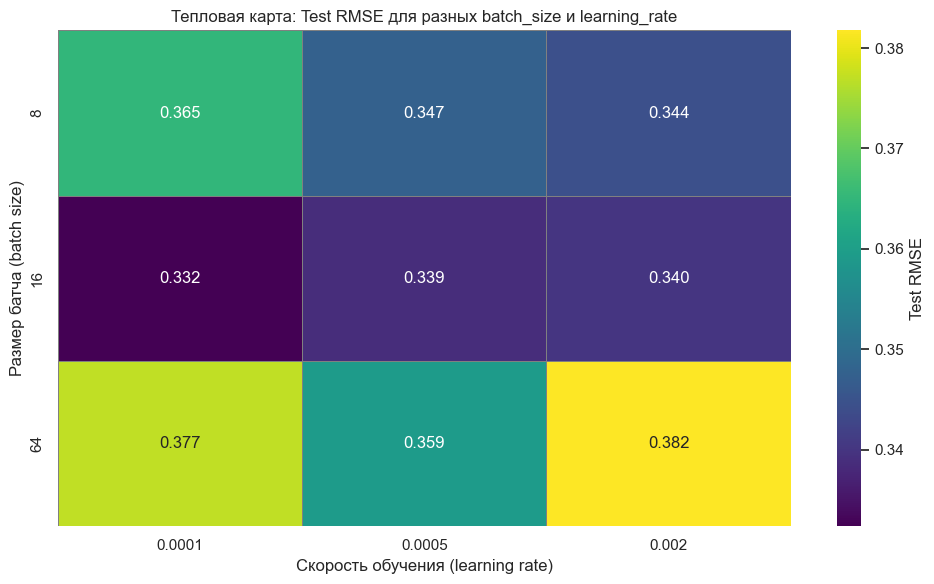

Результаты экспериментов:
   batch_size  learning_rate  best_test_rmse
3          16         0.0001        0.332366
4          16         0.0005        0.338592
5          16         0.0020        0.339961
2           8         0.0020        0.344353
1           8         0.0005        0.347430
7          64         0.0005        0.359240
0           8         0.0001        0.364797
6          64         0.0001        0.377107
8          64         0.0020        0.381754

ЛУЧШИЙ РЕЗУЛЬТАТ:
Batch Size: 16.0
Learning Rate: 0.0001
Test RMSE: 0.33


In [67]:
# Автоматическое создание DataFrame из переменной results
results_df = pd.DataFrame([
    {
        'batch_size': res['batch_size'],
        'learning_rate': res['learning_rate'],
        'best_test_rmse': res['best_test_rmse']
    }
    for res in results
])

# Создаём таблицу для тепловой карты
heatmap_data = results_df.pivot_table(
    index='batch_size',
    columns='learning_rate',
    values='best_test_rmse',
    aggfunc='mean'
)

# Построение heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={'label': 'Test RMSE'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Тепловая карта: Test RMSE для разных batch_size и learning_rate')
plt.xlabel('Скорость обучения (learning rate)')
plt.ylabel('Размер батча (batch size)')
plt.tight_layout()
plt.show()

# Анализ результатов
print("Результаты экспериментов:")
print(results_df.sort_values('best_test_rmse'))

best_result = results_df.loc[results_df['best_test_rmse'].idxmin()]
print(f"\nЛУЧШИЙ РЕЗУЛЬТАТ:")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Test RMSE: {best_result['best_test_rmse']:.2f}")

Согласно результатам экспериментов лучшей нейросетью по метрике RMSE является нейросеть с параметрами: batch_size=16, learning_rate=2е-3. Далее построим график «Факт — Прогноз» и проведем сравнение результатов прогноза двух моделей.

Формирование финальной модели

In [68]:
# Находим лучший результат
best_result = min(results, key=lambda x: x['best_test_rmse'])

print("ВЫГРУЗКА ЛУЧШЕЙ МОДЕЛИ ИЗ ЭКСПЕРИМЕНТОВ")
print("=" * 50)
print(f"Batch Size: {best_result['batch_size']}")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Test RMSE: {best_result['best_test_rmse']:.4f}")
print(f"Обучено эпох: {best_result['final_epoch']}")
print("=" * 50)

# Создаём архитектуру модели (та же, что и в эксперименте)
final_model = NeuralNet(
    input_size=input_size,
    hidden_sizes=[64, 32, 32, 16],
    activation_fn=nn.ReLU(),
    dropout_rate=0.0,
    use_batch_norm=True
).to(device)

# Загружаем веса лучшей модели
final_model.load_state_dict(best_result['best_model_state_dict'])
print("✅ Лучшая модель загружена (веса восстановлены)")

# Сохраняем метрики
final_test_rmse = best_result['best_test_rmse']
final_epoch = best_result['final_epoch']
final_avg_time = best_result['avg_epoch_time']

print(f"Лучший Test RMSE: {final_test_rmse:.4f}")
print(f"Обучено эпох: {final_epoch}")
print(f"Среднее время эпохи: {final_avg_time:.3f}s")

ВЫГРУЗКА ЛУЧШЕЙ МОДЕЛИ ИЗ ЭКСПЕРИМЕНТОВ
Batch Size: 16
Learning Rate: 0.0001
Test RMSE: 0.3324
Обучено эпох: 1400
✅ Лучшая модель загружена (веса восстановлены)
Лучший Test RMSE: 0.3324
Обучено эпох: 1400
Среднее время эпохи: 0.019s


Построим график «Факт — Прогноз» для тестовой выборки, где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной —
температура в Кельвинах.

Модель находится на: cpu
RMSE = 3314.742 K


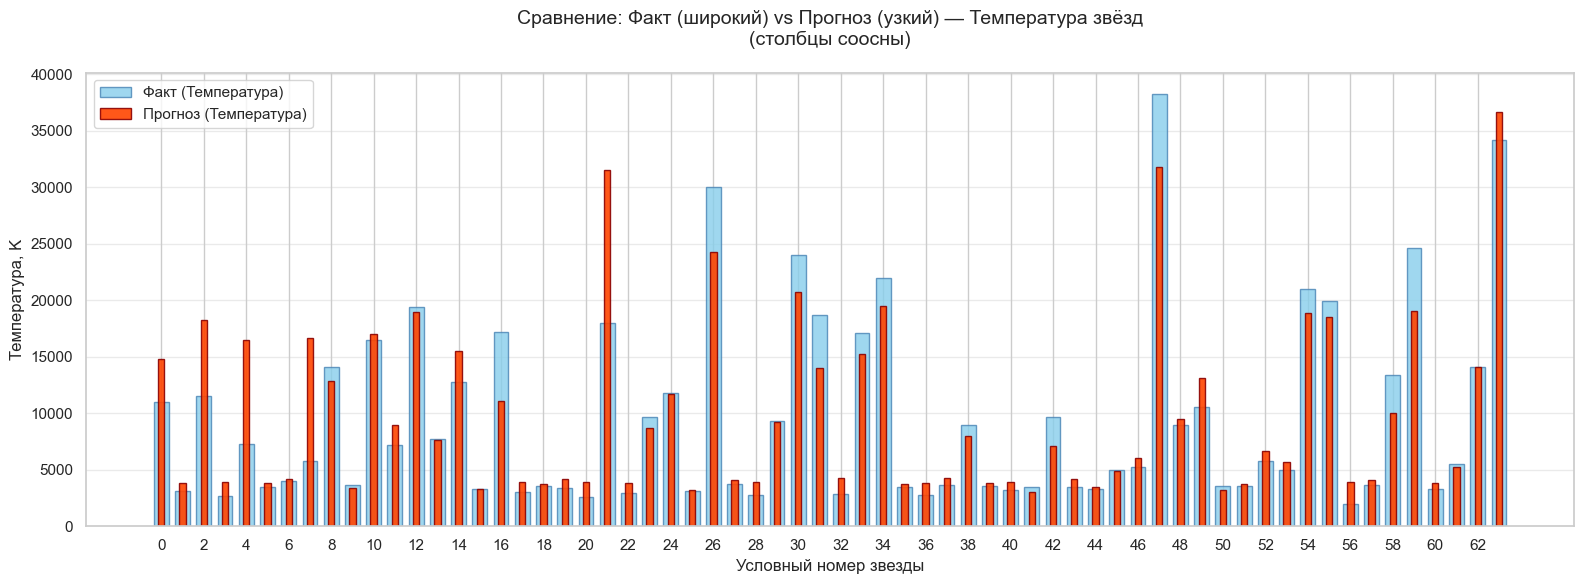

In [69]:
# Определяем устройство модели (или используем глобальное device)
device = next(best_model.parameters()).device  # Узнаём, где модель: CPU или CUDA
print(f"Модель находится на: {device}")

# Переводим модель в режим оценки
final_model.eval()

# Переносим данные на то же устройство, где модель
X_test_tensor_device = X_test_tensor.to(device)
y_test_tensor_device = y_test_tensor.to(device)  # тоже для согласованности

# Получаем предсказания
with torch.no_grad():
    y_pred_tensor = final_model(X_test_tensor_device)

# Преобразуем в numpy (для этого нужно перевести на CPU - доп. проверка)
y_test_np = y_test_true_K
y_pred_np_2 = temp_scaler.inverse_transform(y_pred_tensor.cpu().numpy()).flatten()

# Рассчитываем RMSE в Кельвинах
rmse_2 = rmse(y_test_np, y_pred_np_2)
print(f"RMSE = {rmse_2:.3f} K")

# Условные номера звёзд
indices = np.arange(len(y_test_np))

# Ширина столбцов
width_fact = 0.7  # Широкий
width_pred = 0.3  # Узкий

# Создаём график
plt.figure(figsize=(16, 6))

# Добавляем столбцы: оба центрированы по одной и той же координате
plt.bar(indices, y_test_np, width=width_fact, color='skyblue', label='Факт (Температура)', alpha=0.8, edgecolor='steelblue', linewidth=1)
plt.bar(indices, y_pred_np_2, width=width_pred, color='orangered', label='Прогноз (Температура)', alpha=0.9, edgecolor='darkred', linewidth=1)

# Оформление
plt.title('Сравнение: Факт (широкий) vs Прогноз (узкий) — Температура звёзд\n(столбцы соосны)', fontsize=14, pad=20)
plt.xlabel('Условный номер звезды', fontsize=12)
plt.ylabel('Температура, K', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, axis='y', alpha=0.4)

# Улучшаем ось X: не перегружаем метки
if len(indices) > 20:
    plt.xticks(indices[::2])  # Каждую вторую метку
else:
    plt.xticks(indices)

plt.tight_layout()
plt.show()

Сравнивая графики «Факт — Прогноз» baseline и улучшенной версии сложно сделать какие-либо обобщающие выводы. Для более детального сравнения далее будет представлен отдельный раздел.

**Промежуточные выводы по оптимизированной модели**

1. При использовании архитектуры `Deep + BatchNorm` среди исследуемых параметров `batch_size` — [8, 16, 64], `learning_rate` — [1e-4, 5e-4, 2e-3] нейросеть показала минимальное значение RMSE со следующими значениями: `batch_size`=16, `learning_rate`=2e-3.
2. Улучшенная версия архитектуры дает предсказания с RMSE=3474, что меньше, чем у baseline на 11%.

## Сравнение результатов двух моделей

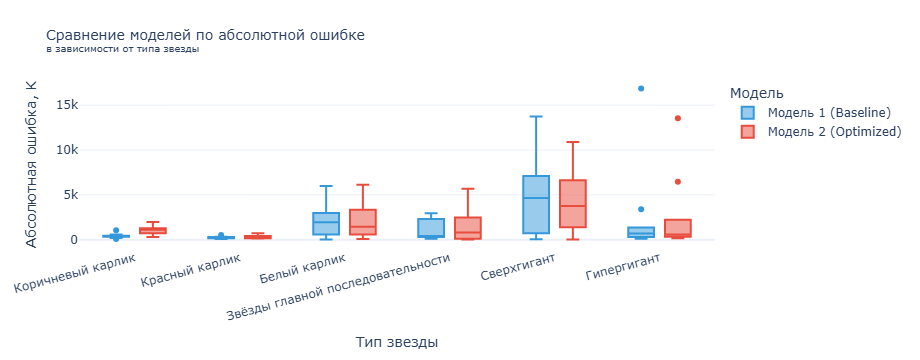

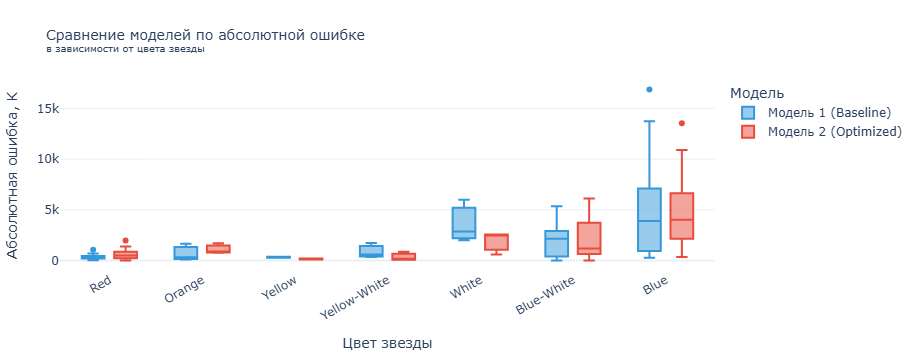

In [70]:
# --- Общие данные ---
star_type_names = {
    0: 'Коричневый карлик',
    1: 'Красный карлик',
    2: 'Белый карлик',
    3: 'Звёзды главной последовательности',
    4: 'Сверхгигант',
    5: 'Гипергигант'
}

# --- OHE-столбцы для цвета (те, что остались после drop='first') ---
color_ohe_columns = [
    'Star color_blue_white',
    'Star color_orange',
    'Star color_red',
    'Star color_white',
    'Star color_yellow',
    'Star color_yellow_white'
]

# Проверка, что все столбцы присутствуют
missing = [col for col in color_ohe_columns if col not in X_test_processed.columns]
if missing:
    raise ValueError(f"Отсутствуют столбцы: {missing}")

# --- Восстанавливаем цвет, включая удалённый класс (предполагаем, что 'blue' был удалён как первый) ---
# Если все OHE-столбцы == 0 → это 'blue'
is_blue = (X_test_processed[color_ohe_columns].sum(axis=1) == 0)
color_labels = pd.Series('Blue', index=X_test_processed.index)  # по умолчанию — Blue

# Для всех остальных: определяем по активному OHE-столбцу
non_blue_mask = ~is_blue
if non_blue_mask.any():
    active_colors = X_test_processed.loc[non_blue_mask, color_ohe_columns].idxmax(axis=1)
    # Преобразуем названия: 'Star color_blue_white' → 'Blue-White'
    mapped = (active_colors
              .str.replace('Star color_', '', regex=False)
              .str.replace('_', ' ', regex=False)
              .str.title()
              .str.replace(' ', '-', regex=False))
    color_labels[non_blue_mask] = mapped

# Теперь у нас есть все цвета: 'Blue', 'Blue-White', 'Orange', 'Red', 'White', 'Yellow', 'Yellow-White'

# --- Создаём DataFrame с результатами ---
results = pd.DataFrame({
    'true': y_test_np,
    'pred1': y_pred_np_1,
    'pred2': y_pred_np_2,
    'type_name': X_test['Star type'].map(star_type_names),
    'color': color_labels.values
})

# --- Ошибки ---
results['error1'] = np.abs(results['pred1'] - results['true'])
results['error2'] = np.abs(results['pred2'] - results['true'])

# --- Переименование моделей ---
model_names = {
    'error1': 'Модель 1 (Baseline)',
    'error2': 'Модель 2 (Optimized)'
}

# --- Порядок категорий ---

# Цвета: от холодных к горячим
color_order = [
    'Red', 'Orange', 'Yellow', 'Yellow-White', 'White', 'Blue-White', 'Blue'
]
# Убираем цвета, которых нет в данных
color_order = [c for c in color_order if c in results['color'].unique()]

# Типы звёзд — в заданном порядке
type_order = list(star_type_names.values())

# --- Цвета для графиков ---
color_map = {
    'Модель 1 (Baseline)': '#3498db',
    'Модель 2 (Optimized)': '#e74c3c'
}

# --- Функция для построения boxplot ---
def plot_error_boxplot(df, group_col, title, xlabel, category_order=None):
    # Подготавливаем данные
    melted = df.melt(
        id_vars=[group_col],
        value_vars=['error1', 'error2'],
        var_name='Model',
        value_name='Absolute Error'
    )
    melted['Model'] = melted['Model'].map(model_names)

    # Добавляем истинную температуру в ховер
    melted['True Temperature (K)'] = df['true'].repeat(2).reset_index(drop=True)

    # График
    fig = px.box(
        melted,
        x=group_col,
        y='Absolute Error',
        color='Model',
        hover_data={
            'Model': True,
            'Absolute Error': ':.1f',
            'True Temperature (K)': ':.0f',
            group_col: False
        },
        title=title,
        labels={
            group_col: xlabel,
            'Absolute Error': 'Абсолютная ошибка, K',
            'Model': 'Модель'
        },
        category_orders={group_col: category_order} if category_order else None,
        color_discrete_map=color_map
    )

    fig.update_layout(
        xaxis_tickangle=-30 if group_col == 'color' else -15,
        legend_title_text='Модель',
        hovermode='closest',
        template='plotly_white',
        font=dict(size=12),
        title_font_size=14,
        margin=dict(l=50, r=50, t=80, b=80)
    )
    fig.show()

# --- Строим графики ---

# По типу звезды
plot_error_boxplot(
    results,
    group_col='type_name',
    title="Сравнение моделей по абсолютной ошибке<br><sup>в зависимости от типа звезды</sup>",
    xlabel="Тип звезды",
    category_order=type_order
)

# По цвету звезды
plot_error_boxplot(
    results,
    group_col='color',
    title="Сравнение моделей по абсолютной ошибке<br><sup>в зависимости от цвета звезды</sup>",
    xlabel="Цвет звезды",
    category_order=color_order
)

Диаграммы boxplot показали, что оптимизированная версия нейросети лучше предсказывает `белых карликов`, `сверхгигантов`, `гипергигантов`, а также следующие цвета: `white`, `blue-white`, `bue`.

C:\Users\shaht\AppData\Local\Temp\ipykernel_596\642770833.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



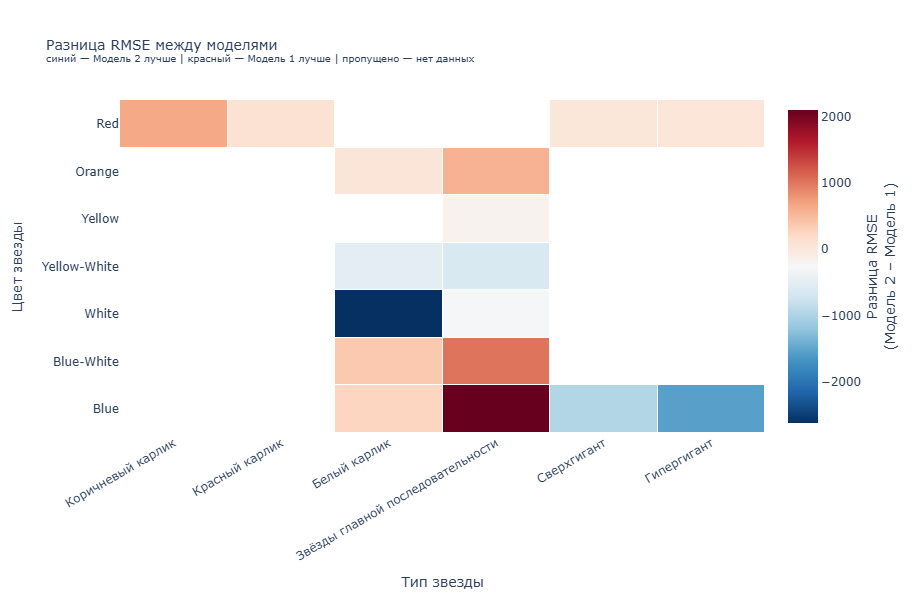

In [71]:
# --- Группировка и расчёт RMSE по группам ---
# Убираем include_groups, так как он не поддерживается в старых версиях pandas
grouped = (results[['color', 'type_name', 'true', 'pred1', 'pred2']]
           .groupby(['color', 'type_name'], group_keys=True)
           .apply(lambda g: pd.Series({
               'rmse1': rmse(g['true'], g['pred1']),
               'rmse2': rmse(g['true'], g['pred2'])
           }))
           .reset_index())

# Разница: M2 - M1 (отрицательное значение = M2 лучше)
grouped['rmse_diff'] = grouped['rmse2'] - grouped['rmse1']

# --- Сводные таблицы с заданным порядком ---
# Убедитесь, что color_order и type_order определены где-то выше
# Например: color_order = ['red', 'blue', ...], type_order = ['A', 'B', ...]

rmse1_pivot = grouped.pivot(index='color', columns='type_name', values='rmse1').reindex(index=color_order, columns=type_order)
rmse2_pivot = grouped.pivot(index='color', columns='type_name', values='rmse2').reindex(index=color_order, columns=type_order)
diff_pivot = grouped.pivot(index='color', columns='type_name', values='rmse_diff').reindex(index=color_order, columns=type_order)

# --- Подготовка текста в ячейках ---
text_labels = []
for i, color in enumerate(diff_pivot.index):
    row = []
    for j, star_type in enumerate(diff_pivot.columns):
        val = diff_pivot.iloc[i, j]
        if pd.isna(val):
            row.append("N/A")
        else:
            row.append(f"{val:+.1f}")  # знак: +1.2 или -0.5
    text_labels.append(row)

# --- Подготовка всплывающих подсказок (hover text) ---
hover_text = []
for i, color in enumerate(diff_pivot.index):
    row = []
    for j, star_type in enumerate(diff_pivot.columns):
        val = diff_pivot.iloc[i, j]
        if pd.isna(val):
            text = f"<b>Нет данных</b><br>Цвет: {color}<br>Тип: {star_type}"
        else:
            text = (
                f"Цвет: {color}<br>"
                f"Тип: {star_type}<br>"
                f"RMSE Модель 1: {rmse1_pivot.iloc[i, j]:.1f}<br>"
                f"RMSE Модель 2: {rmse2_pivot.iloc[i, j]:.1f}<br>"
                f"Разница (M2 - M1): {val:+.1f}"
            )
        row.append(text)
    hover_text.append(row)

# --- Построение тепловой карты ---
fig = go.Figure(data=go.Heatmap(
    z=diff_pivot.values,
    x=diff_pivot.columns.tolist(),
    y=diff_pivot.index.tolist(),
    text=text_labels,
    hovertext=hover_text,
    hoverinfo="text",
    colorscale='RdBu_r',
    zmid=0.0,
    zmin=np.nanmin(diff_pivot.values),
    zmax=np.nanmax(diff_pivot.values),
    colorbar=dict(
        title="Разница RMSE<br>(Модель 2 – Модель 1)",
        titleside="right"
    ),
    xgap=1,
    ygap=1,
    connectgaps=False  # Пропущенные значения остаются пустыми
))

# --- Оформление графика ---
fig.update_layout(
    title="Разница RMSE между моделями<br>"
          "<sup>синий — Модель 2 лучше | красный — Модель 1 лучше | пропущено — нет данных</sup>",
    xaxis_title="Тип звезды",
    yaxis_title="Цвет звезды",
    font=dict(size=12),
    title_font_size=14,
    width=900,
    height=600,
    margin=dict(t=100, l=120, r=60, b=80),
    xaxis=dict(
        tickangle=-30,
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        autorange="reversed",  # Чтобы первый цвет был сверху
        showgrid=False,
        zeroline=False
    ),
    plot_bgcolor='rgba(0,0,0,0)',  # Прозрачный фон
    showlegend=False
)

fig.show()

Тепловая карта «Цвет-Тип» указывает, что улучшенная версия модели делает прогноз температуры с меньшим RMSE для комбинаций звезд (среди имеющихся в датасете): `red-сверхгигант`, все комбинации цветов с белым карликом, `white-звёзды_главной_последовательности`, `blue-сверхгигант`.

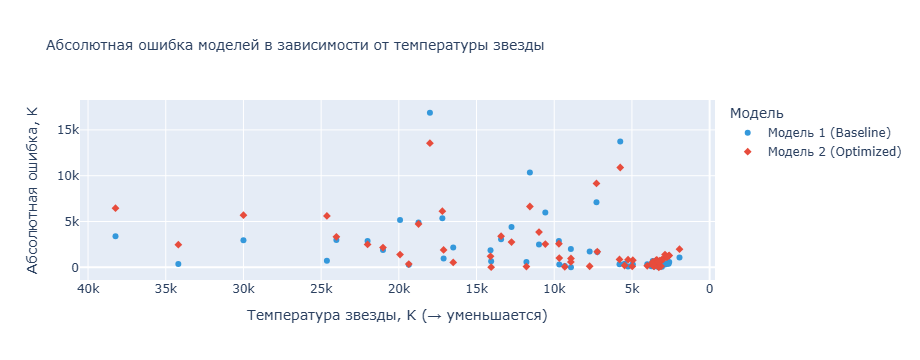

In [72]:
# Используем уже существующий `results`
results_plot = results[['true', 'pred1', 'pred2']].copy()

# Считаем абсолютные ошибки
results_plot['abs_error_1'] = (results_plot['pred1'] - results_plot['true']).abs()
results_plot['abs_error_2'] = (results_plot['pred2'] - results_plot['true']).abs()

# "Длинный" формат
errors_melted = results_plot.melt(
    id_vars=['true'],
    value_vars=['abs_error_1', 'abs_error_2'],
    var_name='Model',
    value_name='Absolute Error'
)

# Переименовываем модели
errors_melted['Model'] = errors_melted['Model'].map({
    'abs_error_1': 'Модель 1 (Baseline)',
    'abs_error_2': 'Модель 2 (Optimized)'
})

# График
fig = px.scatter(
    errors_melted,
    x='true',
    y='Absolute Error',
    color='Model',
    symbol='Model',
    hover_data={'true': ':.0f', 'Absolute Error': ':.1f'},
    labels={
        'true': 'Температура звезды, K',
        'Absolute Error': 'Абсолютная ошибка, K',
        'Model': 'Модель'
    },
    title="Абсолютная ошибка моделей в зависимости от температуры звезды",
    color_discrete_map={
        'Модель 1 (Baseline)': '#3498db',
        'Модель 2 (Optimized)': '#e74c3c'
    },
    category_orders={'Model': ['Модель 1 (Baseline)', 'Модель 2 (Optimized)']}
)

# Ось X: от высоких к низким температурам
fig.update_layout(
    xaxis=dict(
        autorange='reversed',
        title='Температура звезды, K (→ уменьшается)'
    ),
    hovermode='closest',
    legend_title_text='Модель',
    font=dict(size=12),
    title_font_size=14
)

fig.show()

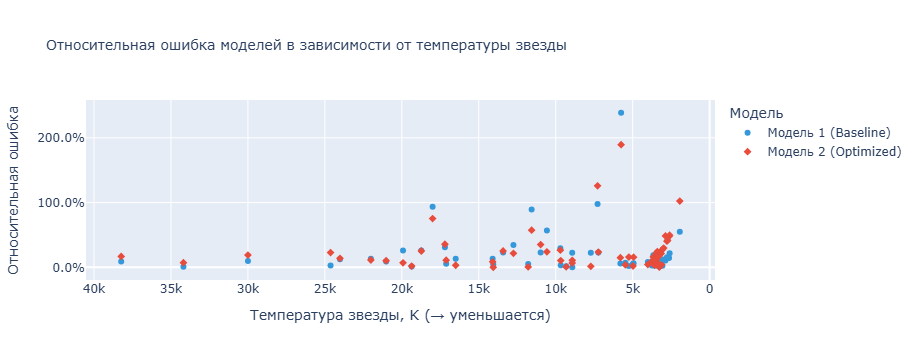

In [73]:
# Используем уже существующий `results`
results_plot = results[['true', 'pred1', 'pred2']].copy()

# Считаем относительные ошибки (с защитой от деления на 0)
results_plot['rel_error_1'] = (results_plot['pred1'] - results_plot['true']).abs() / results_plot['true']
results_plot['rel_error_2'] = (results_plot['pred2'] - results_plot['true']).abs() / results_plot['true']

# "Длинный" формат
errors_melted = results_plot.melt(
    id_vars=['true'],
    value_vars=['rel_error_1', 'rel_error_2'],
    var_name='Model',
    value_name='Relative Error'
)

# Переименовываем модели
errors_melted['Model'] = errors_melted['Model'].map({
    'rel_error_1': 'Модель 1 (Baseline)',
    'rel_error_2': 'Модель 2 (Optimized)'
})

# График
fig = px.scatter(
    errors_melted,
    x='true',
    y='Relative Error',
    color='Model',
    symbol='Model',
    hover_data={
        'true': ':.0f',
        'Relative Error': ':.3f'
    },
    labels={
        'true': 'Температура звезды, K',
        'Relative Error': 'Относительная ошибка',
        'Model': 'Модель'
    },
    title="Относительная ошибка моделей в зависимости от температуры звезды",
    color_discrete_map={
        'Модель 1 (Baseline)': '#3498db',
        'Модель 2 (Optimized)': '#e74c3c'
    },
    category_orders={'Model': ['Модель 1 (Baseline)', 'Модель 2 (Optimized)']}
)

# Ось X: от высоких к низким температурам (холодные справа)
fig.update_layout(
    xaxis=dict(
        autorange='reversed',
        title='Температура звезды, K (→ уменьшается)'
    ),
    yaxis=dict(
        title='Относительная ошибка',
        tickformat='.1%'  # отображаем как проценты: 0.15 → 15.0%
    ),
    hovermode='closest',
    legend_title_text='Модель',
    font=dict(size=12),
    title_font_size=14
)

fig.show()

Что касается непосредственно областей температур, где оптимизированная модель проявляет себя лучше, то это диапазон температур 5750-24000 К.

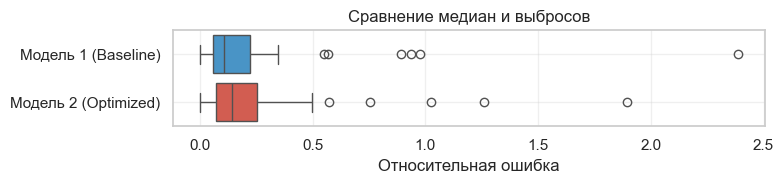

In [74]:
# Сравнение через boxplot
errors_df = pd.DataFrame({
    'Модель 1 (Baseline)': np.abs(y_pred_np_1 - y_test_np) / y_test_np,
    'Модель 2 (Optimized)': np.abs(y_pred_np_2 - y_test_np) / y_test_np
})

plt.figure(figsize=(8, 2))
sns.boxplot(data=errors_df, orient='h', palette=['#3498db', '#e74c3c'])
plt.xlabel('Относительная ошибка')
plt.title('Сравнение медиан и выбросов')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

В завершении анализа важно отметить, что максимальная относительная ошибка у оптимизированной модели уменьшилась с 2 до 1.5, а медиана относительной ошибки сместилась в область больших значений. Смещение медианы в сторону больших значений может быть связано с тем, что звезды со значением температуры меньше 5000 К преобладают в датасете, а в этой области оптимизированная модель проигрывает по ошибке, как отмечено выше.

**Промежуточные выводы по сравнению моделей**

1. Оптимизированная модель дает прогноз с меньшей ошибкой для диапазона температур 5750-24000 К, особенно для белых карликов, сверхгигантов таких цветов как white, blue-white, bue.
2. Максимальная относительная ошибка у оптимизированной модели уменьшилась с 2 до 1.5, а медиана относительной ошибки сместилась в область больших значений.

## Выводы

1. Во время предобработки неявные дубликаты в столбце `Star color` приведены в единый вид. В результате остались следующие цвета звезд: Голубой (Blue), Бело-голубой (Blue-white), Белый (White), Жёлто-белый (Yellow-white), Жёлтый (Yellow), Оранжевый (Orange), Красный (Red). Тип данных в столбце `Star type` переведен в строковый.
3. Числовое описание данных указывает на широкий разброс числовых признаков, равномерное распределение признака `Star type` и неравномерное распределение признака `Star color`.
4. Датасет расширен, чтобы сделать его более репрезентативным, за счет увеличения количества звезд редких цветов: желтого (+6) и оранжевого (+7). Это действие является ценным еще и потому, что категориальные признаки являются важными признаками, по которым можно дать оценку того или иного числового признака, что выяснено в ходе исследовательского анализа. В целом как категориальные, так и числовые признаки являются ценной информацией, так как найден ряд закономерностей.
5. Все признаки достаточно хорошо коррелируют друг с другом (с коэффициентом Phi-k от 0.24 до 0.91). Максимальная корреляция целевого признака температуры с цветом звезды, а не ее типом, поэтому при разделении на тестовую и обучающую выборки для стратификации выбран признак `Star color`.
6. По результатам исследования выбрана архитектура `Deep + BatchNorm`, так как нейронная сеть с ней демонстрирует самую низкую метрику RMSE=3905. График «Факт — Прогноз» указывает на более точные предсказания нейросети для звезд с температурами меньше 5000К, при этом для звезд с температурой больше 5000К относительное отклонение прогноза может быть больше 100%.
7. При использовании архитектуры `Deep + BatchNorm` среди исследуемых параметров `batch_size` — [8, 16, 64], `learning_rate` — [1e-4, 5e-4, 2e-3] нейросеть показала минимальное значение RMSE=3474 со следующими значениями: `batch_size`=16, `learning_rate`=2e-3.
8. Оптимизированная модель дает прогноз с меньшей ошибкой для диапазона температур 5750-24000К, особенно для белых карликов, сверхгигантов таких цветов как white, blue-white, bue. Максимальная относительная ошибка у оптимизированной модели уменьшилась с 2 до 1.5, а медиана относительной ошибки сместилась в область больших значений.